# Figures

Peaks / lengths / differences / jaccard etc.

In [48]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

sns.set_theme(style="whitegrid")

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

ABF_PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
ABF_MODIFICATIONS = ['k4me3', 'k27ac', 'k4me1', 'k27me3', 'k36me3']
ABF_REPLICATES = [f'OD{i}' for i in range(1, 30)] + [f'YD{i}' for i in range(1, 30)]

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics
! mkdir -p {ABF_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        mod = next((m for m in modifications if f'{m}_' in f), None)
        cell = '' if '' in cells else next((c for c in cells if f'{c}_' in f), None)
        rep = next((r for r in replicates if f'_{r}_' in f or f'_{r}-' in f or f.startswith(f'{r}_')), None)
        if rep is None and '' in replicates:
            rep = ''
        if mod and cell is not None and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/1042 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
56   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  HepG2   
177  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K36me3   HSMM   
304  /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K36me3     H1   
94   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   K562   
330  /home/jetbrains/data/2023_GSE26320/span/GSM646...     H3K36me3  Huvec   

    replicate  peaks         tool dataset  
56       rep1   4259        MACS2  ENCODE  
177      rep2  45580        SICER  ENCODE  
304      rep2  19133         SPAN  ENCODE  
94       rep1  52028  MACS2 broad  ENCODE  
330      rep2  30019         SPAN  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/562 [00:00<?, ?it/s]

SPAN 46


file modification     cell  \
19   /home/jetbrains/data/2023_Immune/macs2/CD34_H3...      H3K4me1     CD34   
100  /home/jetbrains/data/2023_Immune/sicer/CD34_H3...      H3K4me3     CD34   
15   /home/jetbrains/data/2023_Immune/macs2/PBMC_H3...      H3K4me3     PBMC   
137  /home/jetbrains/data/2023_Immune/sicer/TCellBB...      H3K4me3  TCellBB   
43   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...      H3K4me3      CD4   

    replicate   peaks   tool  dataset  
19       rep2  148922  MACS2  Roadmap  
100      rep2   20075  SICER  Roadmap  
15              25166  MACS2  Roadmap  
137      rep1   31721  SICER  Roadmap  
43              28519  MACS2  Roadmap

In [9]:
def update_abf_modifications(df):
    df.loc[df['modification'] == 'k4me3', 'modification'] = 'H3K4me3'
    df.loc[df['modification'] == 'k27ac', 'modification'] = 'H3K27ac'
    df.loc[df['modification'] == 'k4me1', 'modification'] = 'H3K4me1'
    df.loc[df['modification'] == 'k27me3', 'modification'] = 'H3K27me3'
    df.loc[df['modification'] == 'k36me3', 'modification'] = 'H3K36me3'

In [10]:
df_abf_peaks_all = load_peaks_path(ABF_PATH, ABF_MODIFICATIONS, [''], ABF_REPLICATES)
update_abf_modifications(df_abf_peaks_all)
df_abf_peaks_all['cell'] = ['OD' if 'OD' in r else 'YD' for r in df_abf_peaks_all['replicate']]
df_abf_peaks_all['dataset'] = 'ABF'
# Drop outliers
ABF_OUTLIERS = {'k27ac': ['YD1', 'YD6'],
                'k27me3': ['OD9', 'YD1', 'YD2', 'YD3', 'YD4', 'YD9', 'YD10', 'YD11'],
                'k36me3': ['OD3', 'OD6', 'OD12', 'OD18', 'OD20', 'YD1', 'YD3', 'YD4', 'YD5'],
                'k4me3': ['OD6', 'OD7', 'OD14', 'YD2', 'YD3', 'YD10', 'YD14']}
t_outliers = [any(f'{o}_h3{m}'.lower() in f.lower() or f'{o}_{m}'.lower() in f.lower()
                  for m, ol in ABF_OUTLIERS.items() for o in ol)
              for f in df_abf_peaks_all['file']]
print('Total outliers', sum(t_outliers))
df_abf_peaks = df_abf_peaks_all[[not to for to in t_outliers]]

df_abf_peaks.sample(5)

  0%|          | 0/1336 [00:00<?, ?it/s]

MACS2 167


  0%|          | 0/1336 [00:00<?, ?it/s]

MACS2 broad 167


  0%|          | 0/167 [00:00<?, ?it/s]

SICER 167


  0%|          | 0/957 [00:00<?, ?it/s]

SPAN 191
Total outliers 32


file modification cell  \
415  /home/jetbrains/data/2018_chipseq_y20o20/sicer...     H3K27me3   OD   
44   /home/jetbrains/data/2018_chipseq_y20o20/macs2...      H3K27ac   YD   
543  /home/jetbrains/data/2018_chipseq_y20o20/span/...     H3K27me3   YD   
668  /home/jetbrains/data/2018_chipseq_y20o20/span/...      H3K4me1   YD   
262  /home/jetbrains/data/2018_chipseq_y20o20/macs2...      H3K27ac   YD   

    replicate   peaks         tool dataset  
415      OD10   13962        SICER     ABF  
44        YD8  114769        MACS2     ABF  
543      YD15   17577         SPAN     ABF  
668       YD6   81769         SPAN     ABF  
262       YD7   97641  MACS2 broad     ABF

In [11]:
df_peaks_full = pd.concat([df_encode_peaks, df_immune_peaks, df_abf_peaks]).reset_index(drop=True)

In [13]:
# Remove outliers
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in
                              df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()

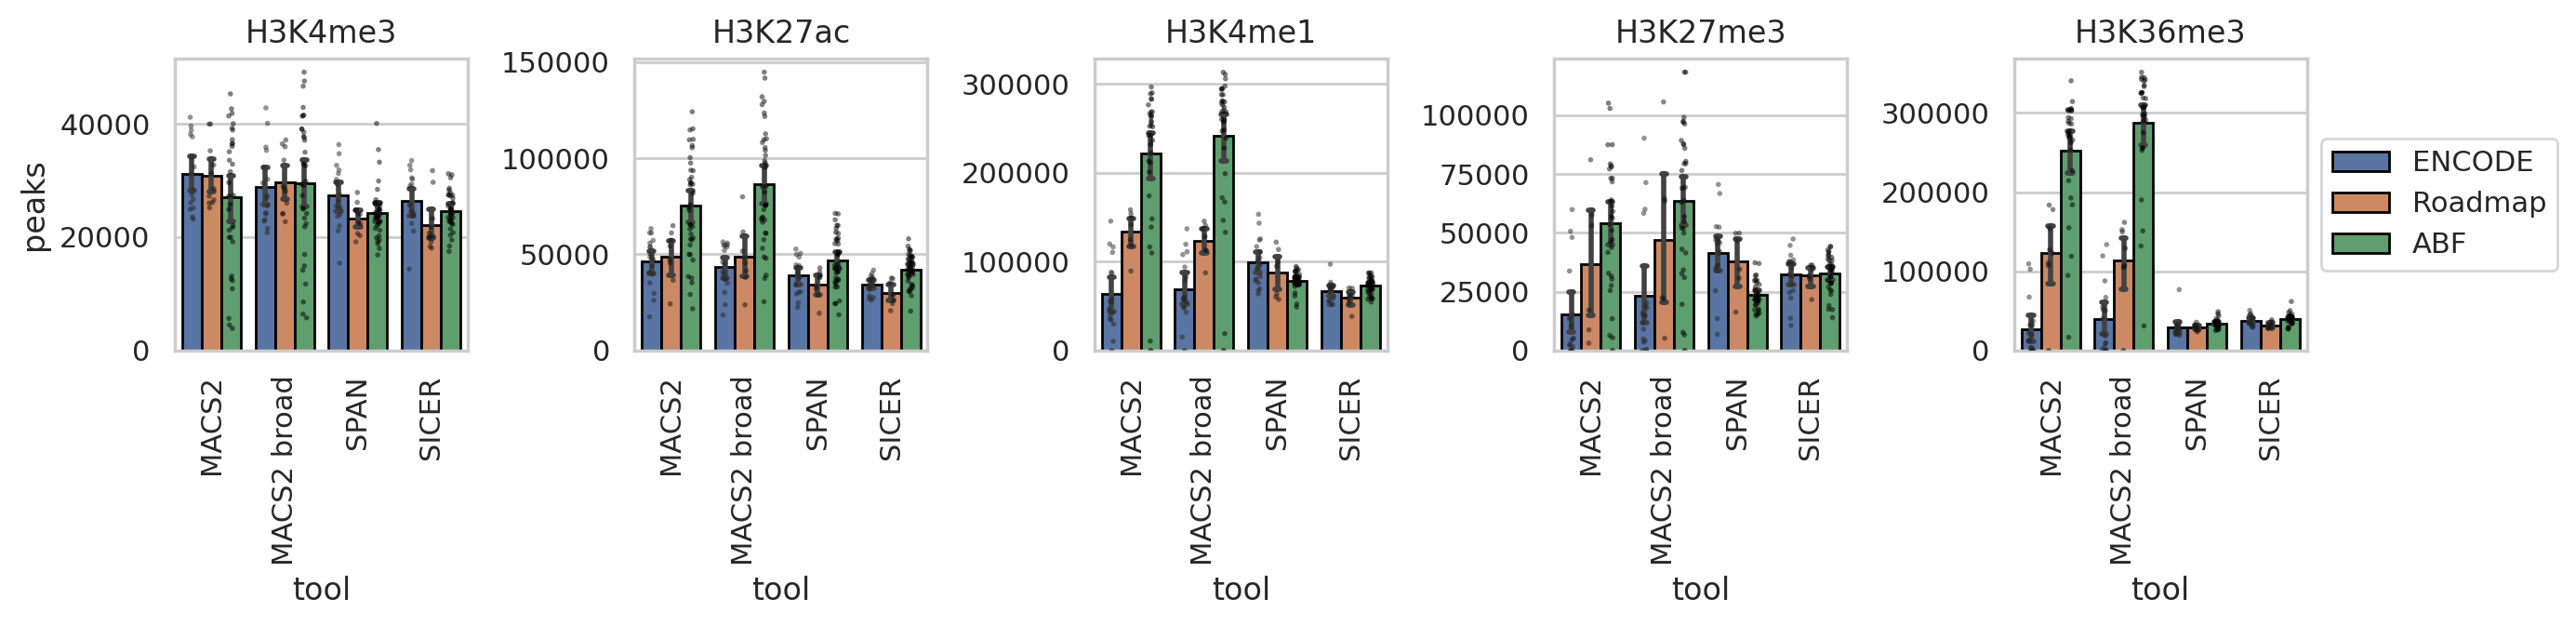

In [14]:
sns.set_style('whitegrid')
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    dfm = df_peaks[df_peaks['modification'] == m]
    sns.barplot(data=dfm, x='tool', y='peaks', hue='dataset',
                capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=dfm, x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

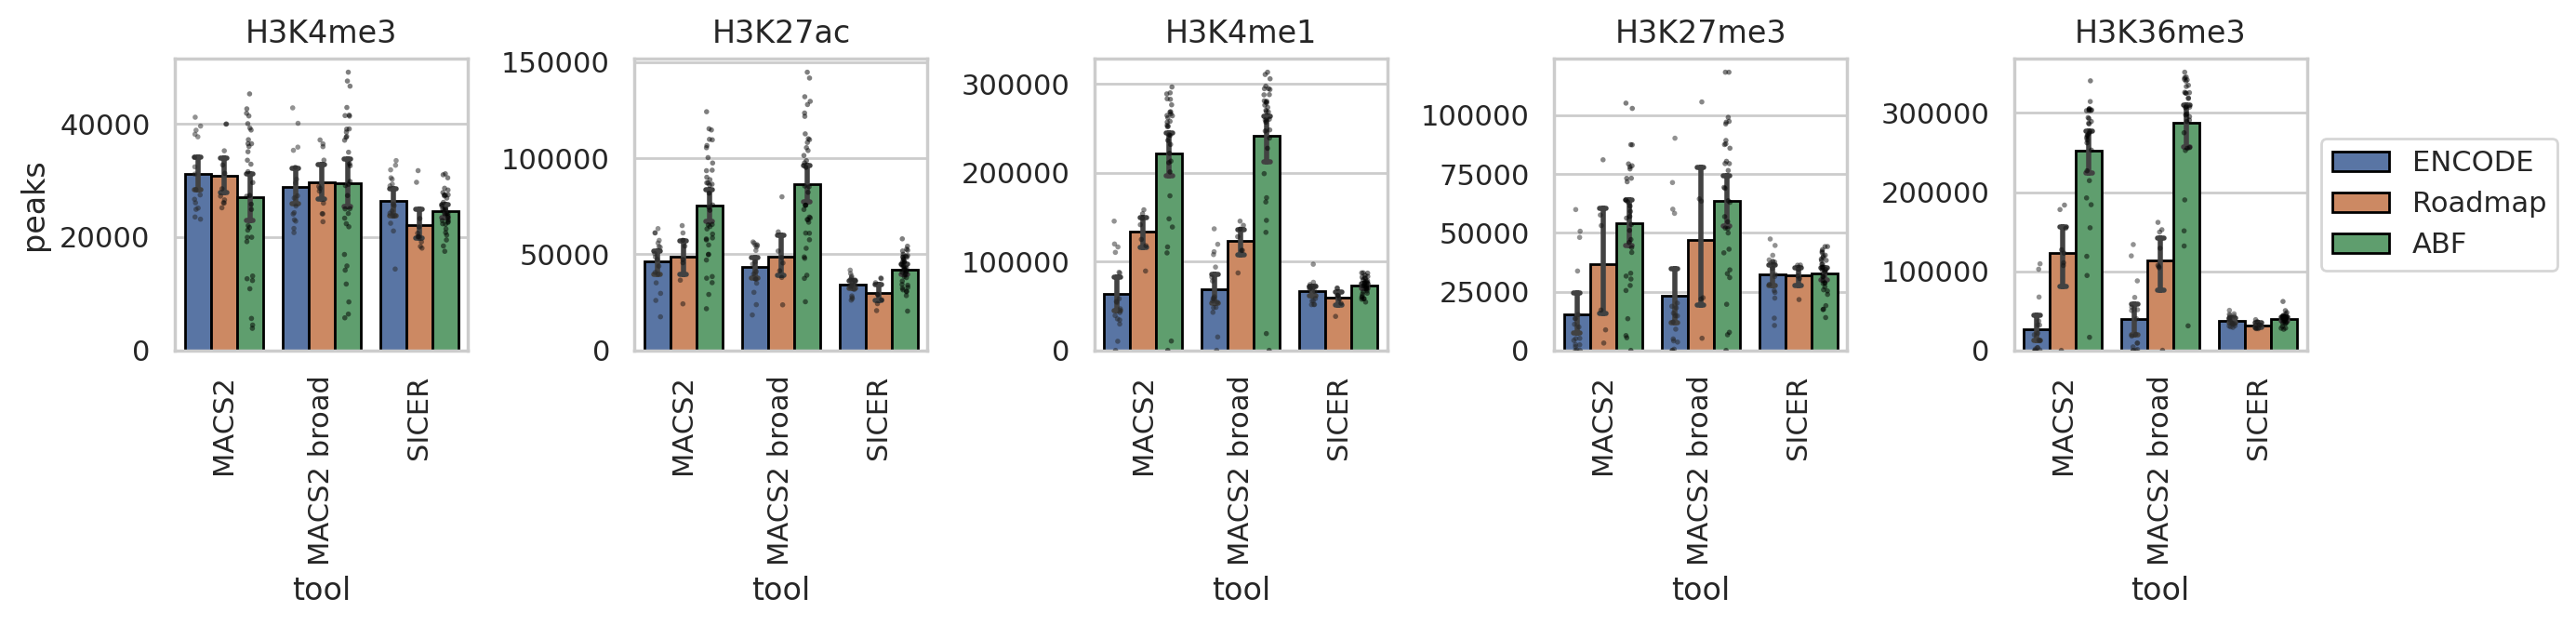

In [16]:
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  # hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Lengths

In [17]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


  0%|          | 0/1160 [00:00<?, ?it/s]

length  dataset modification     cell replicate         tool  \
3016641  1030.0   ENCODE     H3K27me3     K562      rep1         SPAN   
4314704  1399.0  Roadmap      H3K4me3  TCellBB      rep1        SICER   
2293472   599.0   ENCODE      H3K4me3     NHEK      rep2        SICER   
7195363  1601.0      ABF     H3K27me3       OD       OD5  MACS2 broad   
1126617   162.0   ENCODE     H3K27me3     K562      rep2  MACS2 broad   
3296706  1384.0  Roadmap      H3K4me3     PBMC                  MACS2   
7487709   191.0      ABF     H3K36me3       OD       OD4  MACS2 broad   
6325283   369.0      ABF     H3K27me3       YD      YD14        MACS2   
237844    931.0   ENCODE      H3K4me1     NHEK      rep1        MACS2   
1832209  2199.0   ENCODE      H3K27ac  GM12878      rep1        SICER   

         footprint  
3016641  268492045  
4314704   59642679  
2293472   79248565  
7195363   25417362  
1126617    5017796  
3296706   25968954  
7487709  136523278  
6325283    8229124  
237844    80237356  
1832209  124120539

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


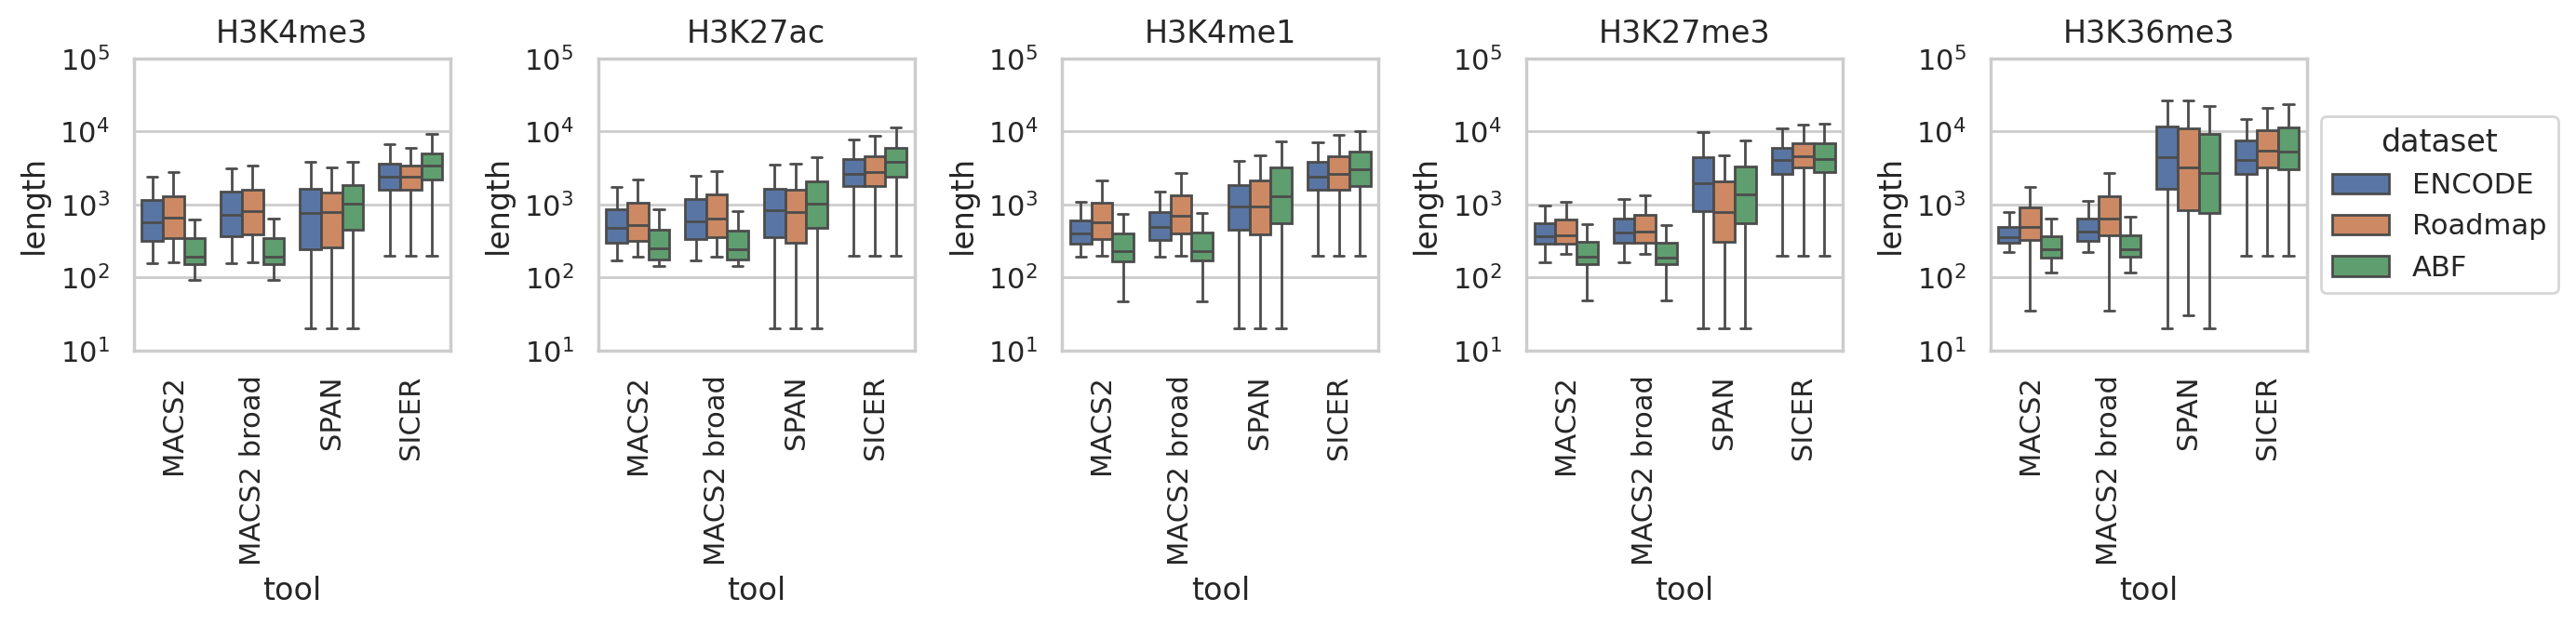

In [19]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens[df_lens['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                # hue_order=['ENCODE', 'Roadmap', 'ABF'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K36me3']:
        ax.set_ylim(bottom=10, top=1e5)
    else:
        ax.set_ylim(bottom=10, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average length

In [20]:
from collections import Counter

ts = []
for (ds, m, c, r, tool), dft in df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['length'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
ts = pd.concat(ts).reset_index(drop=True)
df_lens_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_lens_avg['ds_c_r'] = df_lens_avg['dataset'] + ' ' + df_lens_avg['cell'] + ' ' + df_lens_avg['replicate']
df_lens_avg.sample(3)

dataset modification cell replicate         tool       length  \
273     ABF     H3K27me3   YD       YD7  MACS2 broad   239.679250   
430     ABF      H3K4me1   OD      OD17        SICER  3688.975000   
96      ABF      H3K27ac   YD      YD15        MACS2   287.215125   

       footprint       ds_c_r  
273   44656908.0   ABF YD YD7  
430  273159517.0  ABF OD OD17  
96    41006718.0  ABF YD YD15

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


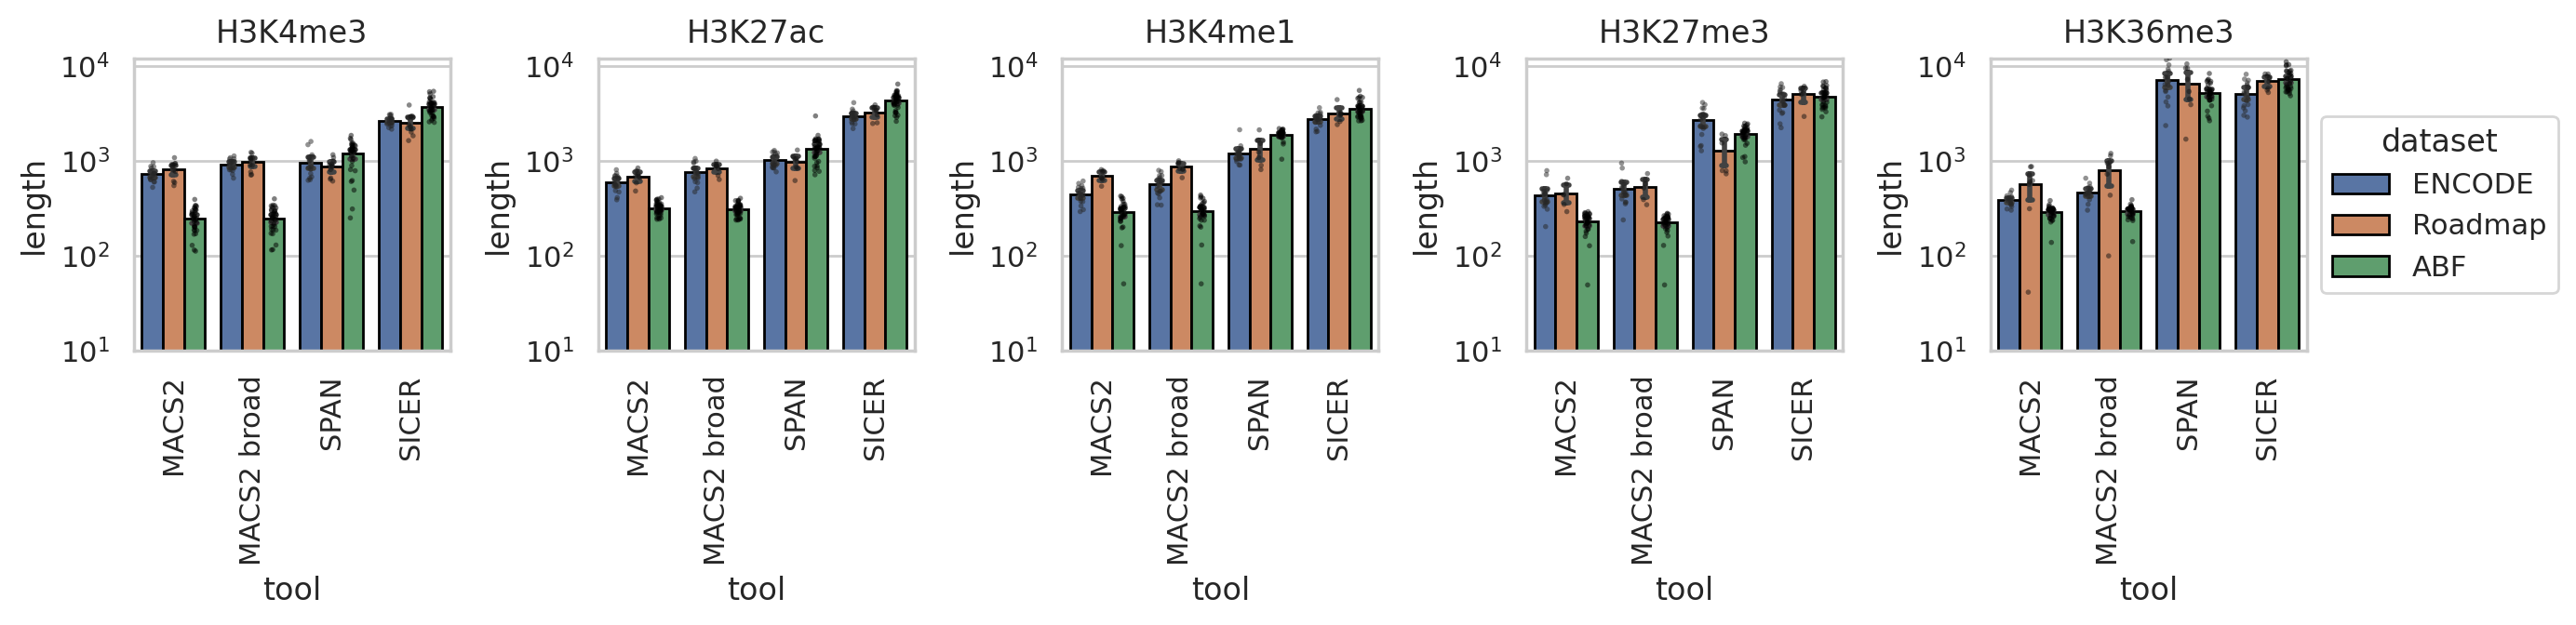

In [23]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.barplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=10, top=1.2e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


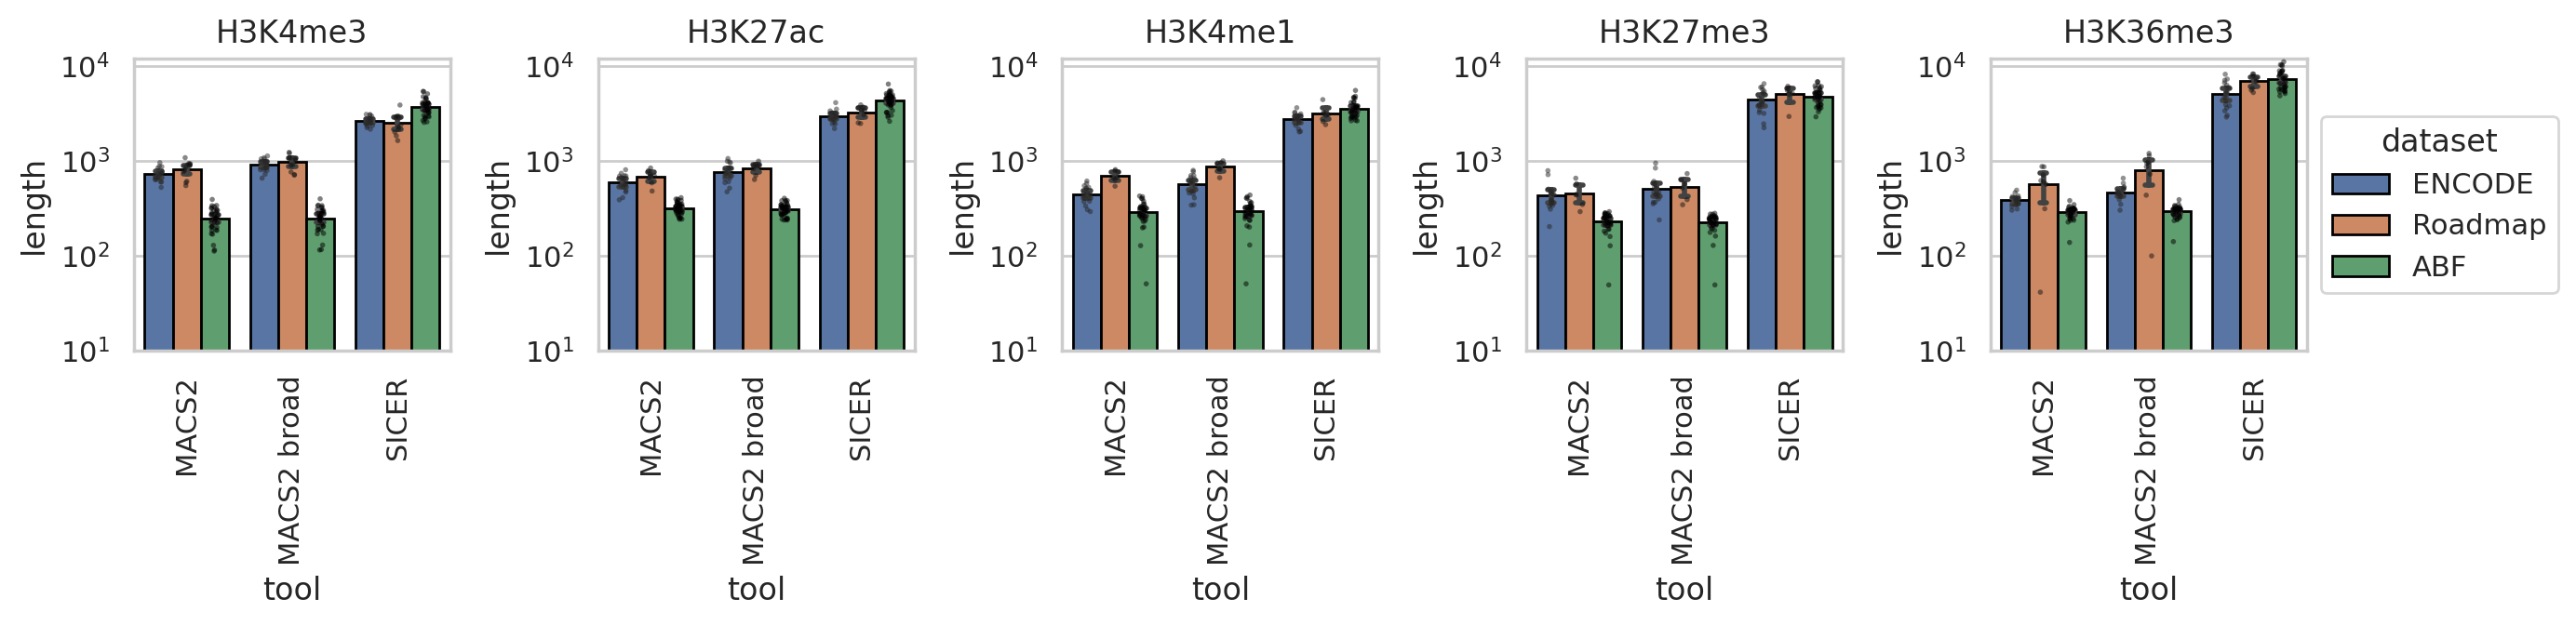

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.barplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(bottom=10, top=1.2e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


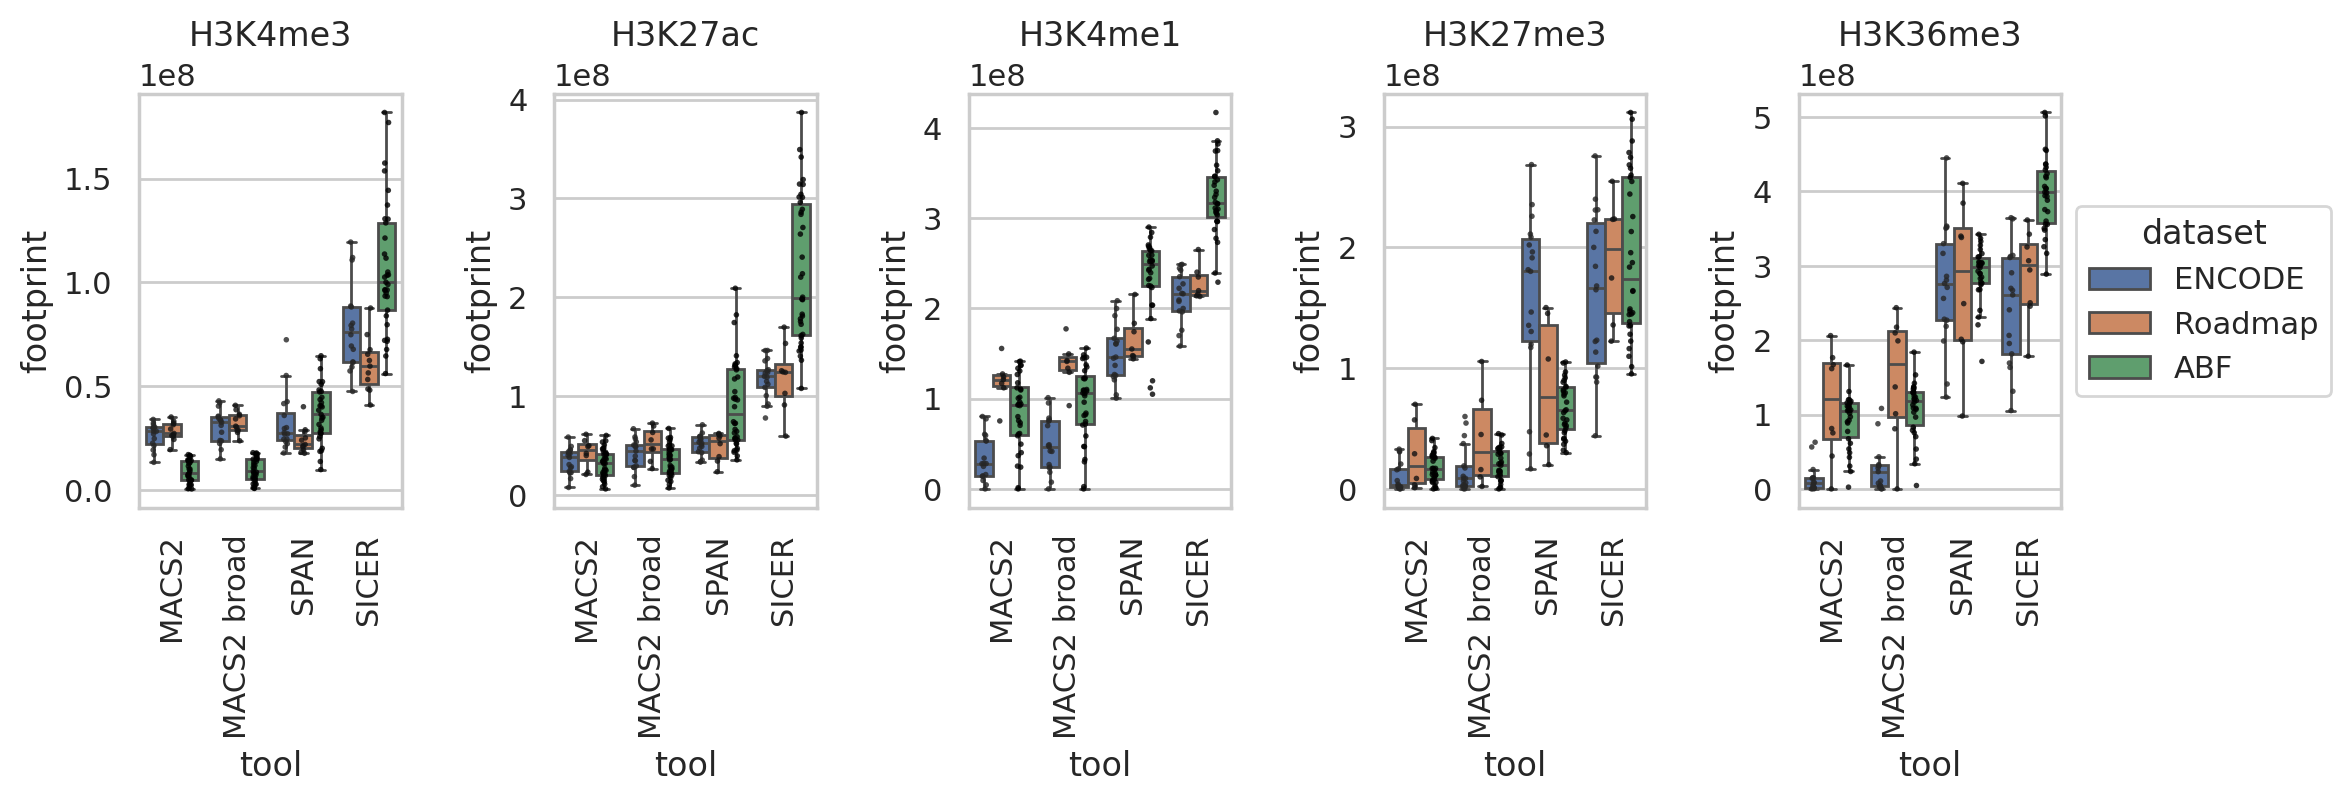

In [25]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    sns.stripplot(data=df_lens_avg[df_lens_avg['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=2, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap', 'ABF'],
                  ax=ax)
    ax.title.set_text(m)

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Distance between peaks

In [26]:
print('Load distances')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
))):
    try:
        tf = pd.read_csv(file, sep='\t', header=None).sort_values(by=[0, 1, 2])
        tss = []
        for chr, tfc in tf.groupby(0):
            starts = tfc[1]
            ends = tfc[2]
            ends = np.roll(ends, 1)
            ds = starts - ends
            t = pd.DataFrame(dict(distance=ds))
            # Ignore first and last
            tss.append(t.iloc[1:min(1_000, len(t) - 1)])
        t = pd.concat(tss).reset_index(drop=True)
        t['dataset'] = dataset
        t['modification'] = mod
        t['cell'] = cell
        t['replicate'] = rep
        t['tool'] = tool
        ts.append(t)
    except:
        pass
df_distances = pd.concat(ts).reset_index(drop=True)
del ts, tss, t
df_distances.sample(10)

Load distances


  0%|          | 0/1160 [00:00<?, ?it/s]

distance  dataset modification  cell replicate   tool
17647582      1201      ABF     H3K36me3    YD      YD20  SICER
10385040      1230      ABF      H3K4me1    OD      OD16  MACS2
6508760       9807  Roadmap      H3K4me3  CD34      rep2  MACS2
335114       73428   ENCODE      H3K27ac  K562      rep1  MACS2
21236578      6805      ABF      H3K4me1    YD      YD20   SPAN
11645707      1419      ABF      H3K4me1    YD       YD8  MACS2
16920706      6401      ABF     H3K36me3    YD       YD9  SICER
11984720     11479      ABF      H3K27ac    OD      OD18  MACS2
10126804         7      ABF      H3K4me3    YD      YD21  MACS2
11156849       759      ABF      H3K4me1    YD      YD19  MACS2

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


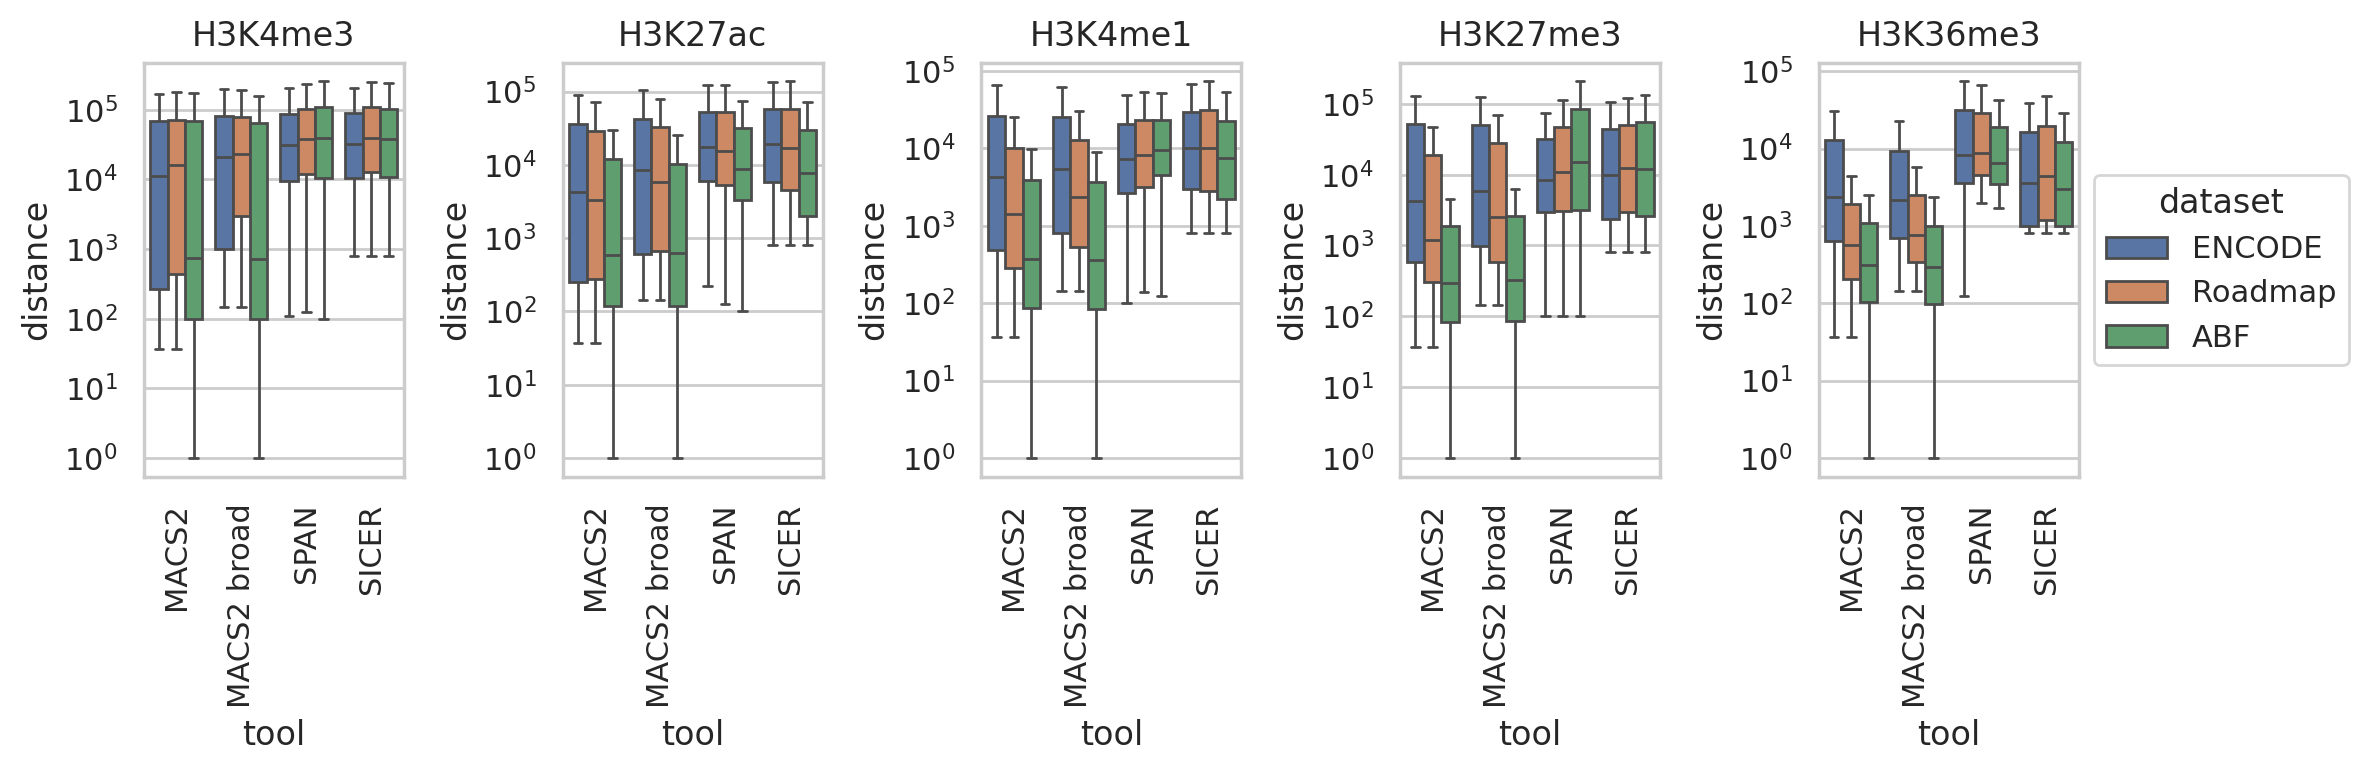

In [27]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_distances[df_distances['modification'] == m],
                x='tool', y='distance', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap', 'ABF'],
                ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Average distance

In [28]:
# Keep % of peaks, since outliers may significantly shift results
ts = []
for (ds, m, c, r, tool), dft in df_distances[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
    dft.sort_values(by=['distance'], inplace=True)
    ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
    # ts.append(dft)
ts = pd.concat(ts).reset_index(drop=True)
df_distances_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
df_distances_avg['ds_c_r'] = df_distances_avg['dataset'] + ' ' + df_distances_avg['cell'] + ' ' + df_distances_avg[
    'replicate']
df_distances_avg.sample(3)

dataset modification  cell replicate         tool      distance  \
723    ENCODE      H3K27ac  NHLF      rep2  MACS2 broad  16650.415746   
65        ABF      H3K27ac    OD       OD6  MACS2 broad   4991.059436   
1084  Roadmap      H3K4me1  CD34                  SICER  17161.212463   

                ds_c_r  
723   ENCODE NHLF rep2  
65          ABF OD OD6  
1084     Roadmap CD34

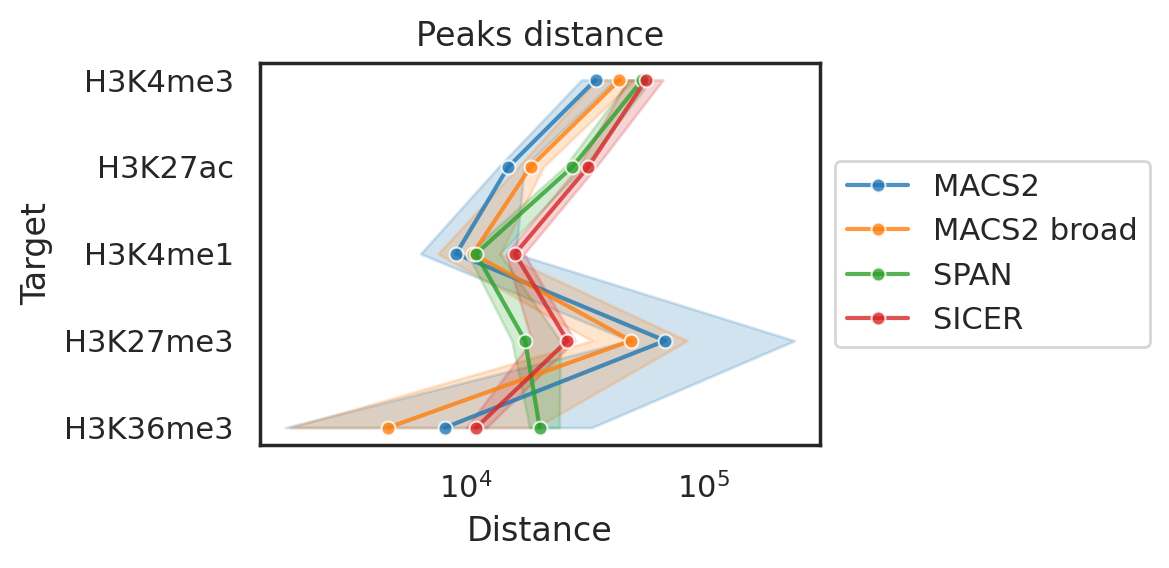

In [49]:
sns.set_theme(style="white")
df_lens['mindex'] = 0
for i, m in enumerate(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    df_distances_avg.loc[df_distances_avg['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
# t = df_lens[df_lens['dataset'].isin(['ENCODE', 'Roadmap', 'ABF'])]
t = df_distances_avg[df_distances_avg['dataset'].isin(['ENCODE', 'Roadmap', ])]
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'distance']),
                         x='distance', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=5
                         )
g_results.axes.set_yticks(range(5), minor=False)
g_results.axes.set_yticklabels(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Distance')
g_results.set(xscale='log')
g_results.axes.title.set_text(f'Peaks distance')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# Avg length vs distance

ENCODE + Roadmap


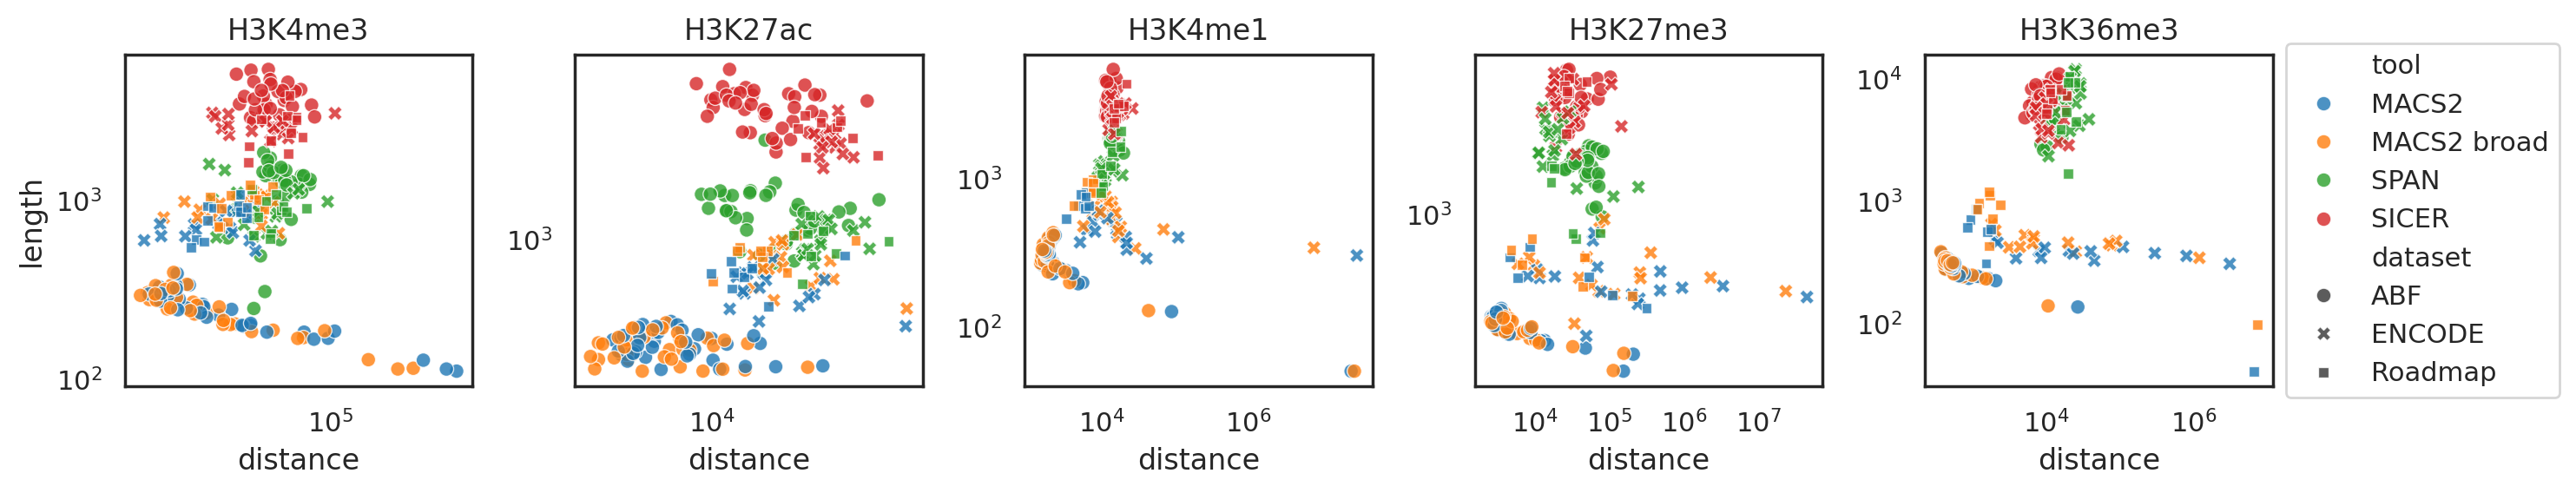

In [30]:
print('ENCODE + Roadmap')
sns.set_theme(style="white")
t = pd.merge(df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']],
             df_distances_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']],
             on=['dataset', 'modification', 'cell', 'replicate', 'tool'])

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(t[(t['modification'] == m)],
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    style='dataset',
                    x='distance', y='length', hue='tool', alpha=0.8,
                    ax=ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(xscale='log')
    ax.set(yscale='log')
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

ENCODE + Roadmap


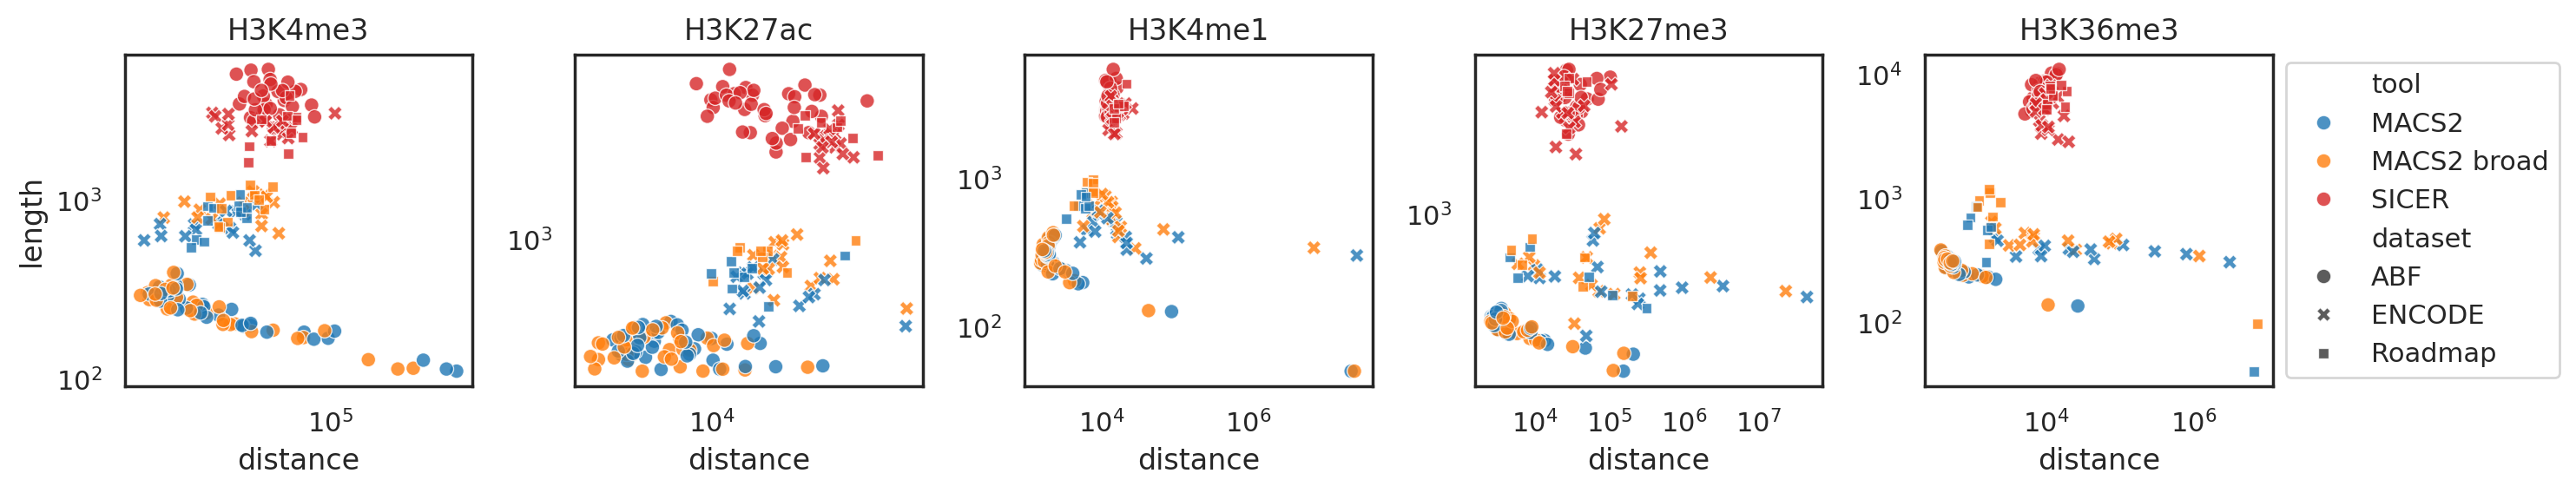

In [31]:
print('ENCODE + Roadmap')
sns.set_theme(style="white")
t = pd.merge(df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']],
             df_distances_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'distance']],
             on=['dataset', 'modification', 'cell', 'replicate', 'tool'])

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(t[(t['modification'] == m) & (t['tool'] != 'SPAN')],
                    palette=TOOLS_PALETTE,
                    hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                    style='dataset',
                    x='distance', y='length',  hue='tool', alpha=0.8,
                    ax=ax)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(xscale='log')
    ax.set(yscale='log')
plt.tight_layout()
plt.show()
sns.set_theme(style="whitegrid")

# ATAC-seq, CTCF info



In [32]:
def simple_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def simple_load_peaks_path(path):
    df_macs2 = simple_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = simple_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2_broad))

    df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = simple_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span]).reset_index(drop=True)

In [33]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
dfa = simple_load_peaks_path(ATAC_PATH)
dfa

  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 185


  0%|          | 0/1480 [00:00<?, ?it/s]

MACS2 broad 185


  0%|          | 0/185 [00:00<?, ?it/s]

SICER 185


  0%|          | 0/2220 [00:00<?, ?it/s]

SPAN 185


file  peaks   tool
0    /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  17421  MACS2
1    /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  64081  MACS2
2    /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  21233  MACS2
3    /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  29318  MACS2
4    /home/jetbrains/data/2024_Immgen/macs2/SRR5799...  37337  MACS2
..                                                 ...    ...    ...
735  /home/jetbrains/data/2024_Immgen/span/SRR57993...  61335   SPAN
736  /home/jetbrains/data/2024_Immgen/span/SRR57994...  35921   SPAN
737  /home/jetbrains/data/2024_Immgen/span/SRR57994...  52074   SPAN
738  /home/jetbrains/data/2024_Immgen/span/SRR57994...  53589   SPAN
739  /home/jetbrains/data/2024_Immgen/span/SRR57994...  37165   SPAN

[740 rows x 3 columns]

In [34]:
ts = []
for tool, file in tqdm(zip(dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t.sort_values(by=['length'], inplace=True)
    t = t.sample(min(len(t), 10_000)).copy()
    t = t.iloc[: int(len(t) * 0.9)].copy()  # ATAC-seq may include large domains, skip them
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_lens = pd.concat(ts).reset_index(drop=True)
dfa_lens['modification'] = 'ATAC'
dfa_lens['dataset'] = 'Immgen'
dfa_lens_avg = dfa_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_lens_avg.sample(10))

0it [00:00, ?it/s]

dataset modification         tool  \
690  Immgen         ATAC         SPAN   
197  Immgen         ATAC  MACS2 broad   
290  Immgen         ATAC  MACS2 broad   
469  Immgen         ATAC        SICER   
305  Immgen         ATAC  MACS2 broad   
637  Immgen         ATAC         SPAN   
739  Immgen         ATAC         SPAN   
531  Immgen         ATAC        SICER   
388  Immgen         ATAC        SICER   
648  Immgen         ATAC         SPAN   

                                                  file       length  
690  /home/jetbrains/data/2024_Immgen/span/SRR57995...   538.713889  
197  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   252.927111  
290  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   229.089000  
469  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  1959.888889  
305  /home/jetbrains/data/2024_Immgen/macs2/SRR5799...   227.970667  
637  /home/jetbrains/data/2024_Immgen/span/SRR57994...   516.927222  
739  /home/jetbrains/data/2024_Immgen/span/SRR81864...   928.667222  
531  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  1904.644444  
388  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  3675.733333  
648  /home/jetbrains/data/2024_Immgen/span/SRR57994...   421.023889

In [35]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf = simple_load_peaks_path(CTCF_PATH)
display(df_ctcf)

  0%|          | 0/72 [00:00<?, ?it/s]

MACS2 9


  0%|          | 0/72 [00:00<?, ?it/s]

MACS2 broad 9


  0%|          | 0/9 [00:00<?, ?it/s]

SICER 9


  0%|          | 0/108 [00:00<?, ?it/s]

SPAN 9


file   peaks         tool
0   /home/jetbrains/data/2024_TFs/macs2/Monocyte_C...   25256        MACS2
1   /home/jetbrains/data/2024_TFs/macs2/GM12878_re...   79833        MACS2
2   /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_EN...   95602        MACS2
3   /home/jetbrains/data/2024_TFs/macs2/NHLF_CTCF_...   44865        MACS2
4   /home/jetbrains/data/2024_TFs/macs2/BCell_CTCF...   40339        MACS2
5   /home/jetbrains/data/2024_TFs/macs2/K562_rep1_...   52679        MACS2
6   /home/jetbrains/data/2024_TFs/macs2/NK_CTCF_EN...   27728        MACS2
7   /home/jetbrains/data/2024_TFs/macs2/CD4_CTCF_E...   31522        MACS2
8   /home/jetbrains/data/2024_TFs/macs2/HepG2_rep1...   86998        MACS2
9   /home/jetbrains/data/2024_TFs/macs2/Monocyte_C...   27007  MACS2 broad
10  /home/jetbrains/data/2024_TFs/macs2/BCell_CTCF...   43024  MACS2 broad
11  /home/jetbrains/data/2024_TFs/macs2/NHLF_CTCF_...   46753  MACS2 broad
12  /home/jetbrains/data/2024_TFs/macs2/NK_CTCF_EN...   30511  MACS2 broad
13  /home/jetbrains/data/2024_TFs/macs2/GM12878_re...   92344  MACS2 broad
14  /home/jetbrains/data/2024_TFs/macs2/K562_rep1_...   56442  MACS2 broad
15  /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_EN...   98214  MACS2 broad
16  /home/jetbrains/data/2024_TFs/macs2/HepG2_rep1...  109732  MACS2 broad
17  /home/jetbrains/data/2024_TFs/macs2/CD4_CTCF_E...   33133  MACS2 broad
18  /home/jetbrains/data/2024_TFs/sicer/HepG2_rep1...   68164        SICER
19  /home/jetbrains/data/2024_TFs/sicer/BCell_CTCF...   30415        SICER
20  /home/jetbrains/data/2024_TFs/sicer/H1_CTCF_EN...   69006        SICER
21  /home/jetbrains/data/2024_TFs/sicer/NHLF_CTCF_...   35671        SICER
22  /home/jetbrains/data/2024_TFs/sicer/Monocyte_C...   22438        SICER
23  /home/jetbrains/data/2024_TFs/sicer/K562_rep1_...   40625        SICER
24  /home/jetbrains/data/2024_TFs/sicer/CD4_CTCF_E...   25241        SICER
25  /home/jetbrains/data/2024_TFs/sicer/GM12878_re...   52348        SICER
26  /home/jetbrains/data/2024_TFs/sicer/NK_CTCF_EN...   26765        SICER
27  /home/jetbrains/data/2024_TFs/span/HepG2_rep1_...   85540         SPAN
28  /home/jetbrains/data/2024_TFs/span/NHLF_CTCF_E...   43104         SPAN
29  /home/jetbrains/data/2024_TFs/span/GM12878_rep...   87314         SPAN
30  /home/jetbrains/data/2024_TFs/span/CD4_CTCF_EN...   32136         SPAN
31  /home/jetbrains/data/2024_TFs/span/Monocyte_CT...   24741         SPAN
32  /home/jetbrains/data/2024_TFs/span/NK_CTCF_ENC...   27536         SPAN
33  /home/jetbrains/data/2024_TFs/span/K562_rep1_C...   56276         SPAN
34  /home/jetbrains/data/2024_TFs/span/H1_CTCF_ENC...   96861         SPAN
35  /home/jetbrains/data/2024_TFs/span/BCell_CTCF_...   40697         SPAN

In [36]:
ts = []
for tool, file in tqdm(zip(df_ctcf['tool'], df_ctcf['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    t['file'] = file
    ts.append(t)
dfa_ctcf_lens = pd.concat(ts).reset_index(drop=True)
dfa_ctcf_lens['modification'] = 'CTCF'
dfa_ctcf_lens['dataset'] = 'CTCF'
dfa_ctcf_lens_avg = dfa_ctcf_lens.groupby(['dataset', 'modification', 'tool', 'file']).agg('mean').reset_index()
del ts
display(dfa_ctcf_lens_avg.sample(3))

0it [00:00, ?it/s]

dataset modification         tool  \
15    CTCF         CTCF  MACS2 broad   
13    CTCF         CTCF  MACS2 broad   
14    CTCF         CTCF  MACS2 broad   

                                                 file    length  
15  /home/jetbrains/data/2024_TFs/macs2/Monocyte_C...  330.8229  
13  /home/jetbrains/data/2024_TFs/macs2/HepG2_rep1...  174.5854  
14  /home/jetbrains/data/2024_TFs/macs2/K562_rep1_...  323.1714

In [37]:
# Keep % of peaks, since outliers may significantly shift results
tracks_per_dataset = 20
ds_counter = Counter()
ts = []
for (ds, m, tool), dft in pd.concat([df_lens_avg, dfa_ctcf_lens_avg, dfa_lens_avg]).groupby(['dataset', 'modification', 'tool']):
    c = ds_counter[(ds, m, tool)]
    if c >= tracks_per_dataset:
        continue
    ds_counter[(ds, m, tool)] += (tracks_per_dataset - c)
    ts.append(dft.head(tracks_per_dataset - c))

df_lens_balanced_avg = pd.concat(ts).reset_index()
display(df_lens_balanced_avg.sample(3))
# ds_counter

index dataset modification   cell replicate         tool     length  \
344    545     ABF      H3K4me3     OD      OD13  MACS2 broad   339.6775   
748    972  ENCODE      H3K4me3  Huvec      rep2        SICER  2509.9000   
749    976  ENCODE      H3K4me3   K562      rep1        SICER  2520.4750   

      footprint             ds_c_r file  
344  13283824.0        ABF OD OD13  NaN  
748  59212726.0  ENCODE Huvec rep2  NaN  
749  88614994.0   ENCODE K562 rep1  NaN

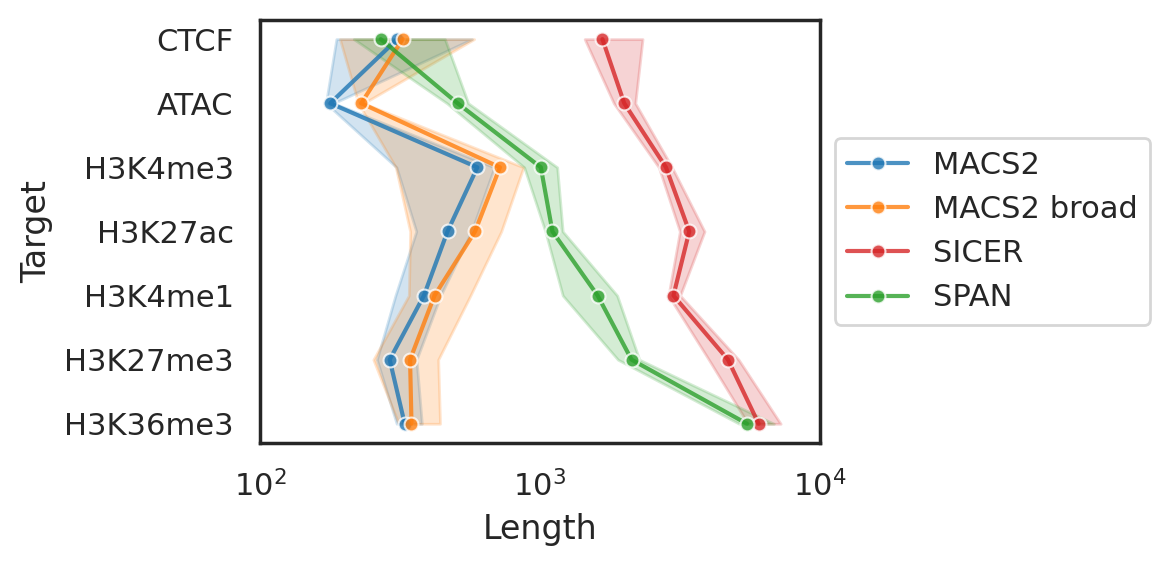

In [38]:
t = df_lens_balanced_avg.copy()

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=5
                         )
g_results.axes.set_yticks(range(7), minor=False)
g_results.axes.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(100, 1.0e4)
g_results.axes.title.set_text(f'')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

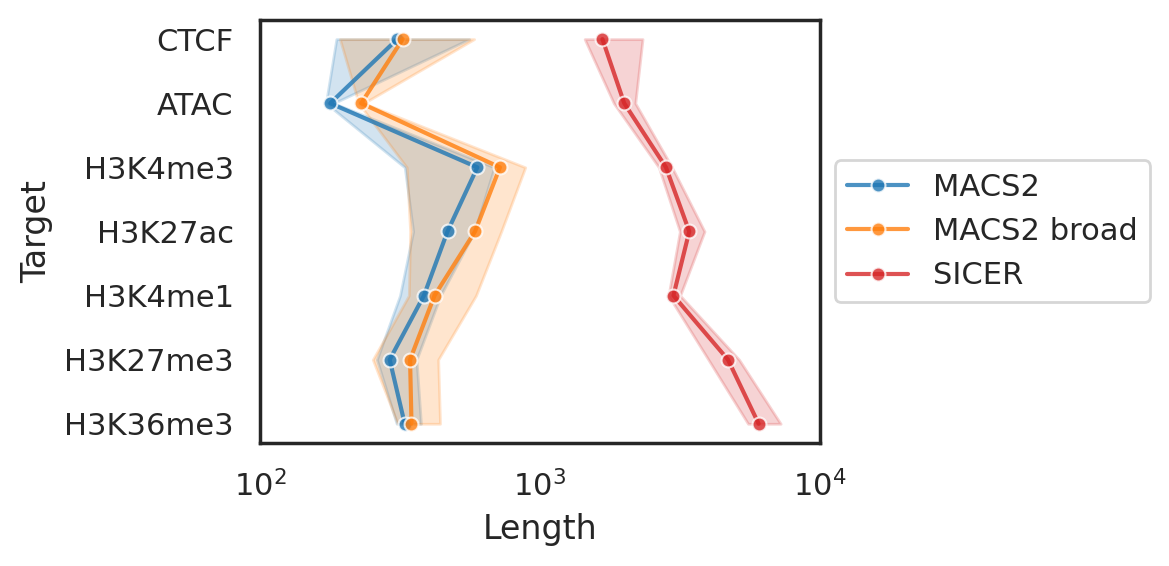

In [39]:
t = df_lens_balanced_avg.copy()

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                         palette=TOOLS_PALETTE,
                         marker='o', markersize=5
                         )
g_results.axes.set_yticks(range(7), minor=False)
g_results.axes.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(100, 1.0e4)
g_results.axes.title.set_text(f'')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# BAMs

In [40]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if mod and cell is not None and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [41]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_abf_bams = load_bams(ABF_PATH + '/bams', ABF_MODIFICATIONS, [''], ABF_REPLICATES, 'input')
update_abf_modifications(df_abf_bams)
df_abf_bams['dataset'] = 'ABF'
reads = ! samtools view -F 0x04 -c {ABF_PATH}/bams/input.bam
reads = int(reads[0])
df_abf_bams.loc[len(df_abf_bams)] = (f'{ABF_PATH}/bams/input.bam', 'Control', '', '', reads, 'ABF')

df_bams = pd.concat([df_encode_bams, df_immune_bams, df_abf_bams]).reset_index(drop=True)

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

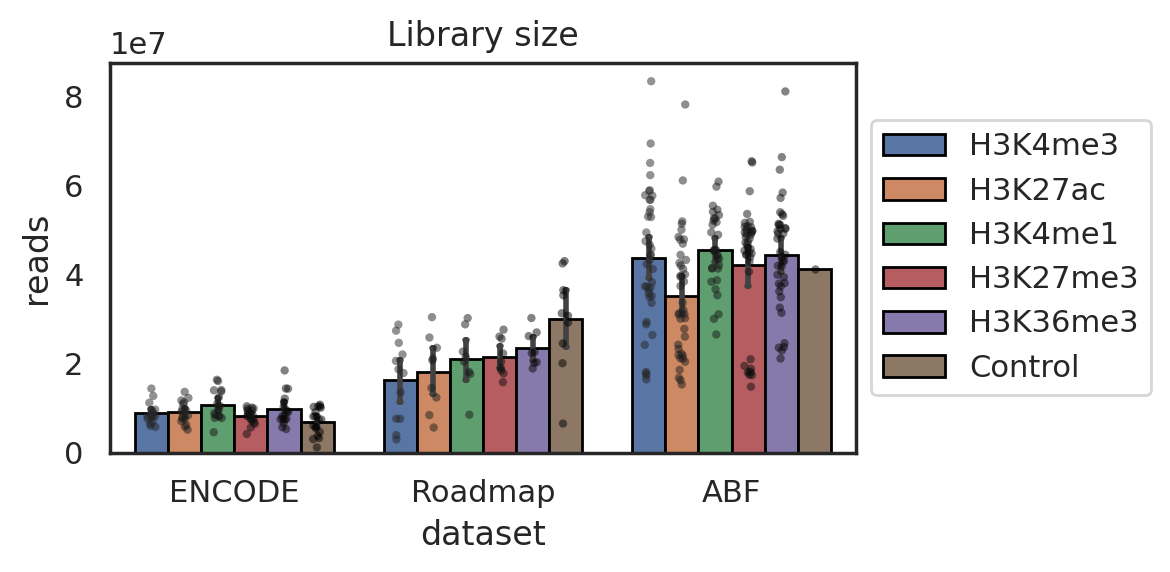

In [42]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, err_kws={'linewidth': 2}, edgecolor="black",
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.stripplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [43]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_avg[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

dataset modification  cell replicate         tool   peaks     reads  \
484  Roadmap      H3K4me3  CD34      rep2         SPAN   19154  13539143   
176   ENCODE      H3K27ac  K562      rep2        SICER   26159   6180094   
396  Roadmap      H3K4me1  CD34            MACS2 broad  140715  17619839   

          length    footprint  
484   904.477500   19271320.0  
176  2544.625000   78015441.0  
396   996.195625  177299718.0



peaks vs length


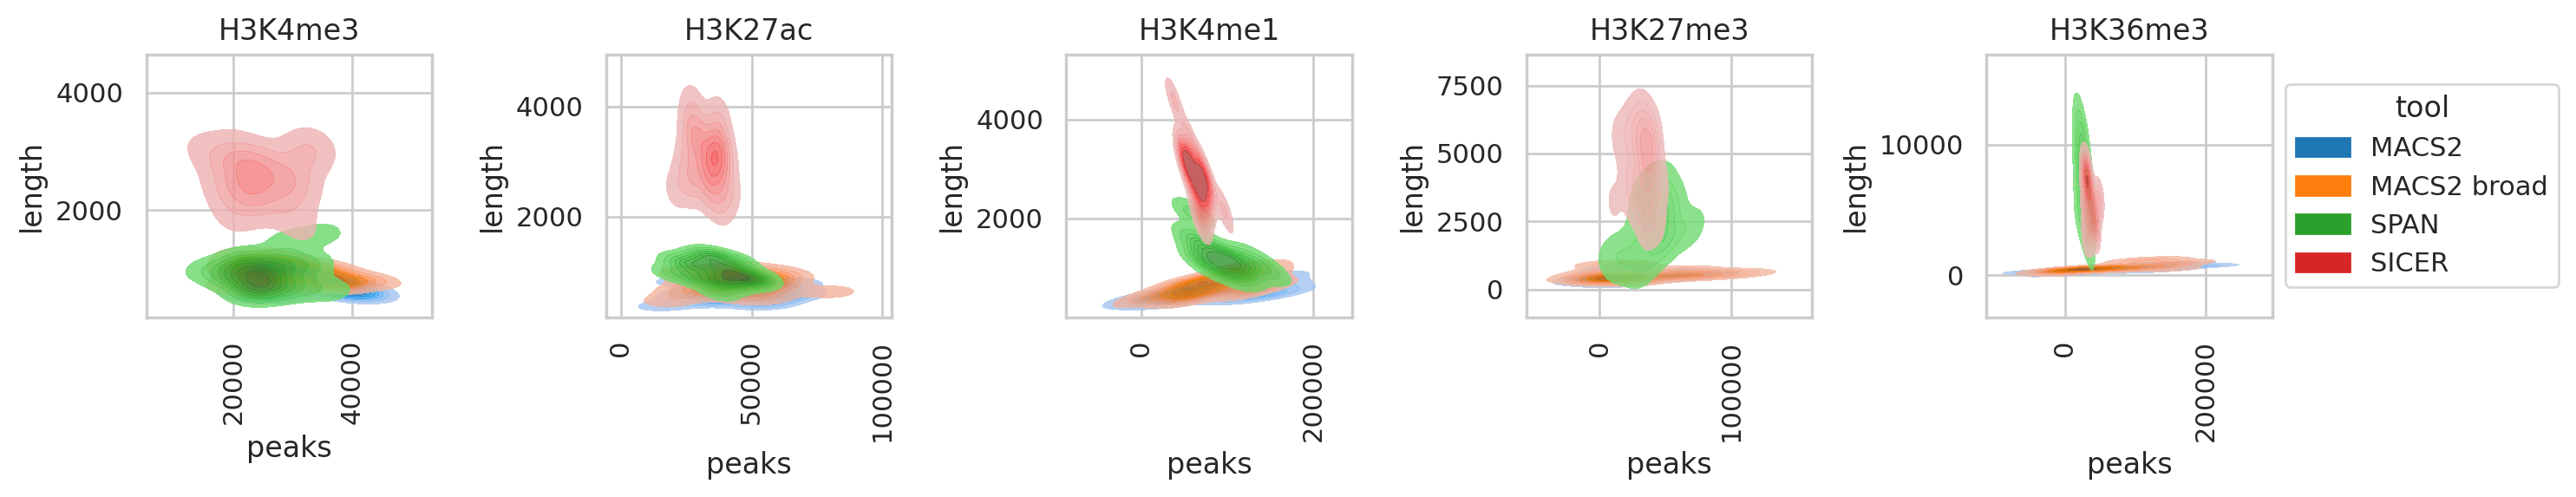



peaks vs reads


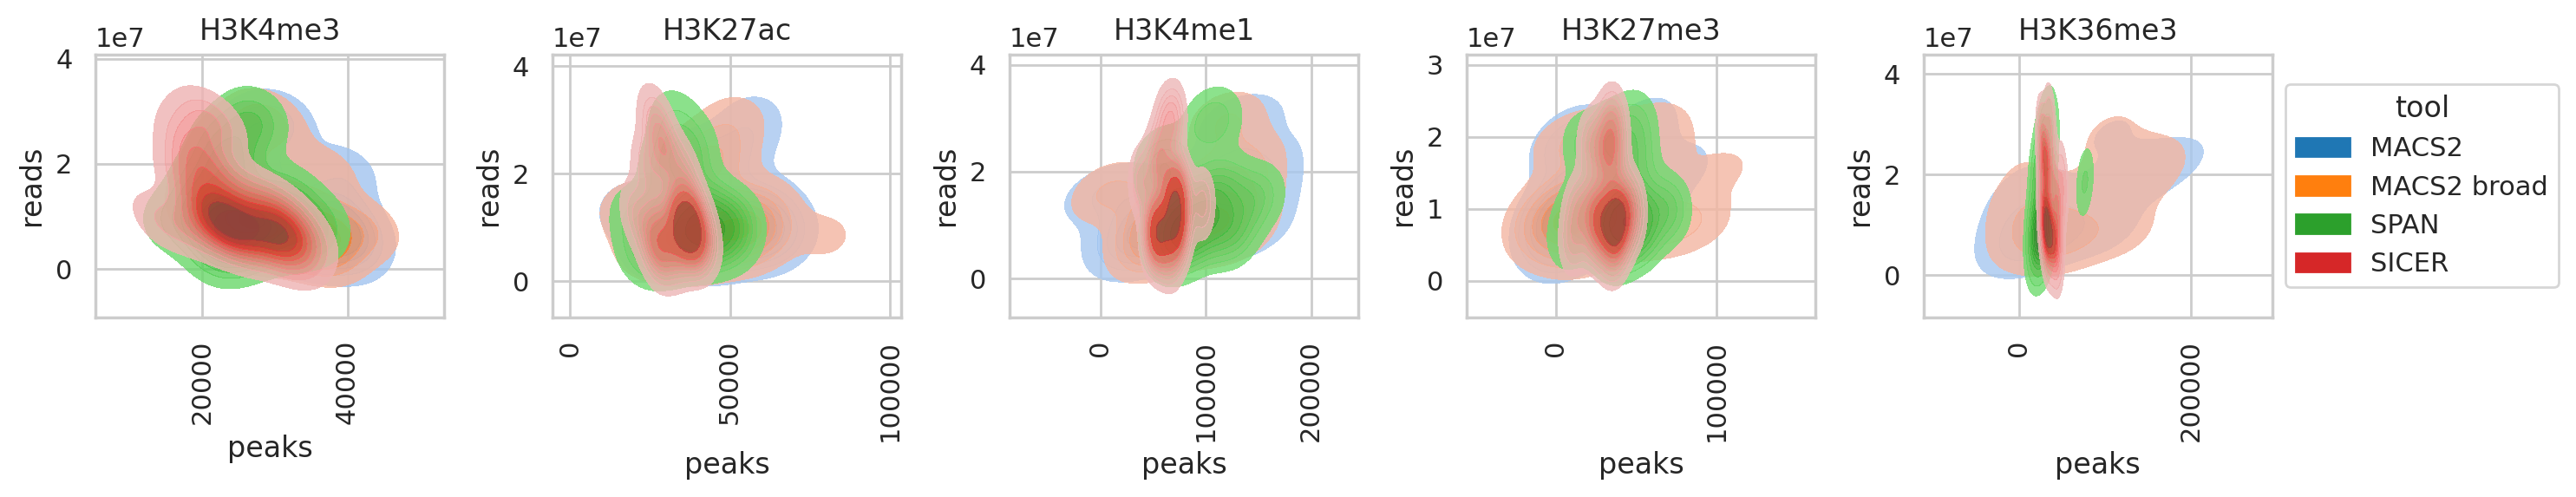

In [52]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.kdeplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool',
            alpha=0.8,
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            thresh=0.05,
            fill=True,
            legend=i == len(axs) - 1,
            ax=ax)
        ax.title.set_text(m)
        if i == len(axs) - 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# Difference

In [45]:
def compute_diffs(diff_path, df):
    tools = df['tool'].unique()
    rows = []
    for (m, c, r), tmcr in tqdm(list(df.groupby(['modification', 'cell', 'replicate']))):
        print(m, c, r)
        t = tmcr[tmcr['tool'] == 'SPAN']
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = tmcr[tmcr['tool'] == tool]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                diff_file = f'{diff_path}/{name.replace(" ", "_")}_{m}_{c}_{r}.bed'
                ! bedtools intersect {args} -wa -v > {diff_file}
                peaks = lines(diff_file)
                rows.append((m, c, r, name, peaks))
    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

In [46]:
def plot_diff(df_peaks, df_diff):
    t = df_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
    t.rename({'tool': 'name'}, axis=1, inplace=True)
    t = pd.concat([t, df_diff]).reset_index(drop=True)
    t = t.loc[
        [(m, c, r) not in OUTLIERS for _, (m, c, r) in t[['modification', 'cell', 'replicate']].iterrows()]].copy()

    plt.figure(figsize=(18, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tm = t[t['modification'] == m]
        print(m, len(t))
        ax.set_title(m)
        sns.barplot(data=tm, x='name', y='peaks',
                    color='grey',
                    capsize=.2, err_kws={'linewidth': 2},
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                           'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                           'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                           ],
                    ax=ax)
        sns.stripplot(data=tm, x='name', y='peaks',
                      size=2, alpha=0.8, color='black',
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                             'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                             'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                             ],
                      legend=False,
                      ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Peaks number')
    plt.tight_layout()
    plt.show()

## ENCODE

In [53]:
dp = f'{GSE26320_PATH}/diff'
! mkdir -p {dp}
df_encode_diff = compute_diffs(dp, df_encode_peaks)
df_encode_diff.sample(5)

  0%|          | 0/85 [00:00<?, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac H1 rep1
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27me3 GM12878 rep1
H3K27me3 GM12878 rep2
H3K27me3 H1 rep1
H3K27me3 H1 rep2
H3K27me3 HMEC rep1
H3K27me3 HMEC rep2
H3K27me3 HSMM rep1
H3K27me3 HSMM rep2
H3K27me3 HepG2 rep1
H3K27me3 HepG2 rep2
H3K27me3 Huvec rep1
H3K27me3 Huvec rep2
H3K27me3 K562 rep1
H3K27me3 K562 rep2
H3K27me3 NHEK rep1
H3K27me3 NHEK rep2
H3K27me3 NHLF rep1
H3K27me3 NHLF rep2
H3K36me3 GM12878 rep1
H3K36me3 GM12878 rep2
H3K36me3 H1 rep1
H3K36me3 H1 rep2
H3K36me3 HMEC rep1
H3K36me3 HMEC rep2
H3K36me3 HSMM rep1
H3K36me3 HSMM rep2
H3K36me3 HepG2 rep1
H3K36me3 HepG2 rep2
H3K36me3 Huvec rep1
H3K36me3 Huvec rep2
H3K36me3 K562 rep1
H3K36me3 K562 rep2
H3K36me3 NHEK rep2
H3K36me3 NHLF rep1
H3K36me3 NHLF rep2
H3K4me1 G

modification   cell replicate                name  peaks
484      H3K4me3   K562      rep1        SPAN - SICER   2349
208     H3K27me3   NHLF      rep2        SPAN - SICER  15254
343      H3K4me1   HMEC      rep2        MACS2 - SPAN     40
51       H3K27ac  HepG2      rep2  MACS2 broad - SPAN    165
284     H3K36me3   K562      rep1  SPAN - MACS2 broad  15854

H3K4me3 850
H3K27ac 850
H3K4me1 850
H3K27me3 850
H3K36me3 850


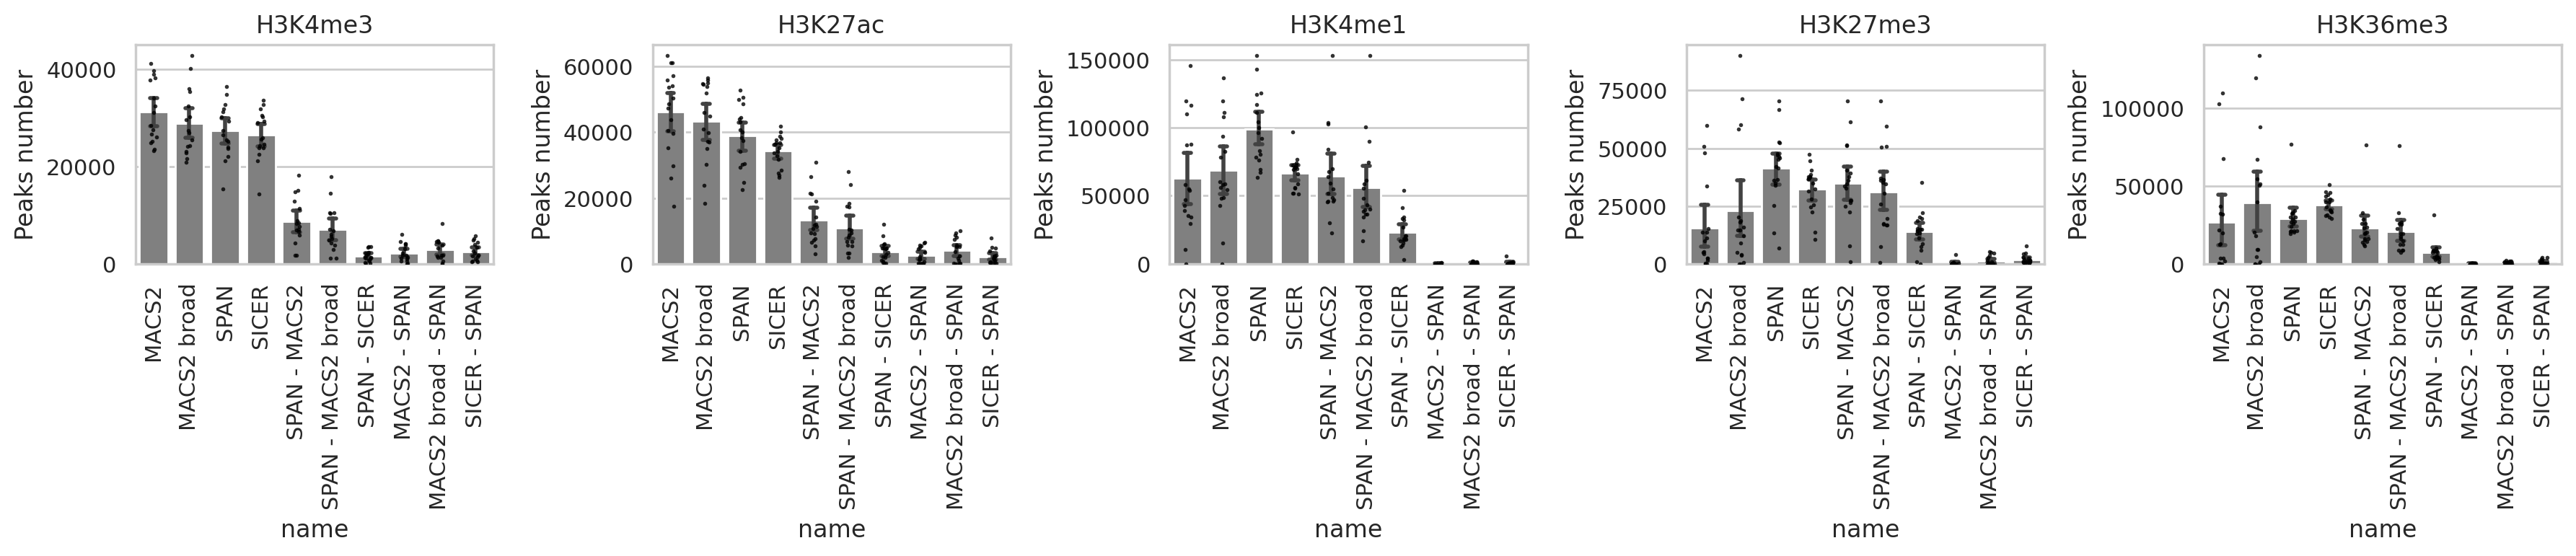

In [54]:
plot_diff(df_encode_peaks, df_encode_diff)

## Roadmap

In [55]:
dp = f'{IMMUNE_PATH}/diff'
! mkdir -p {dp}
df_immune_diff = compute_diffs(dp, df_immune_peaks)
df_immune_diff.sample(5)

  0%|          | 0/46 [00:00<?, ?it/s]

H3K27ac BCell 
H3K27ac CD34 
H3K27ac CD34 rep2
H3K27ac CD4 
H3K27ac CD4 rep1
H3K27ac Monocyte 
H3K27ac NK 
H3K27ac PBMC 
H3K27ac TCell 
H3K27me3 BCell 
H3K27me3 CD34 
H3K27me3 CD34 rep2
H3K27me3 CD4 
H3K27me3 CD4 rep2
H3K27me3 Monocyte 
H3K27me3 NK 
H3K27me3 PBMC 
H3K27me3 TCell 
H3K36me3 BCell 
H3K36me3 CD34 
H3K36me3 CD34 rep1
H3K36me3 CD4 
H3K36me3 CD4 rep1
H3K36me3 Monocyte 
H3K36me3 PBMC 
H3K36me3 TCell 
H3K4me1 BCell 
H3K4me1 CD34 
H3K4me1 CD34 rep2
H3K4me1 CD4 
H3K4me1 CD4 rep1
H3K4me1 Monocyte 
H3K4me1 NK 
H3K4me1 TCell 
H3K4me3 BCell 
H3K4me3 CD34 
H3K4me3 CD34 rep2
H3K4me3 CD4 
H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 Monocyte 
H3K4me3 NK 
H3K4me3 PBMC 
H3K4me3 TCell 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2


modification      cell replicate                name  peaks
16       H3K27ac      CD34      rep2        SPAN - SICER    332
183      H3K4me1       CD4      rep1  MACS2 broad - SPAN    931
35       H3K27ac  Monocyte                  SICER - SPAN   3421
73      H3K27me3       CD4                  MACS2 - SPAN      9
126     H3K36me3       CD4                  SPAN - MACS2  12150

H3K4me3 400
H3K27ac 400
H3K4me1 400
H3K27me3 400
H3K36me3 400


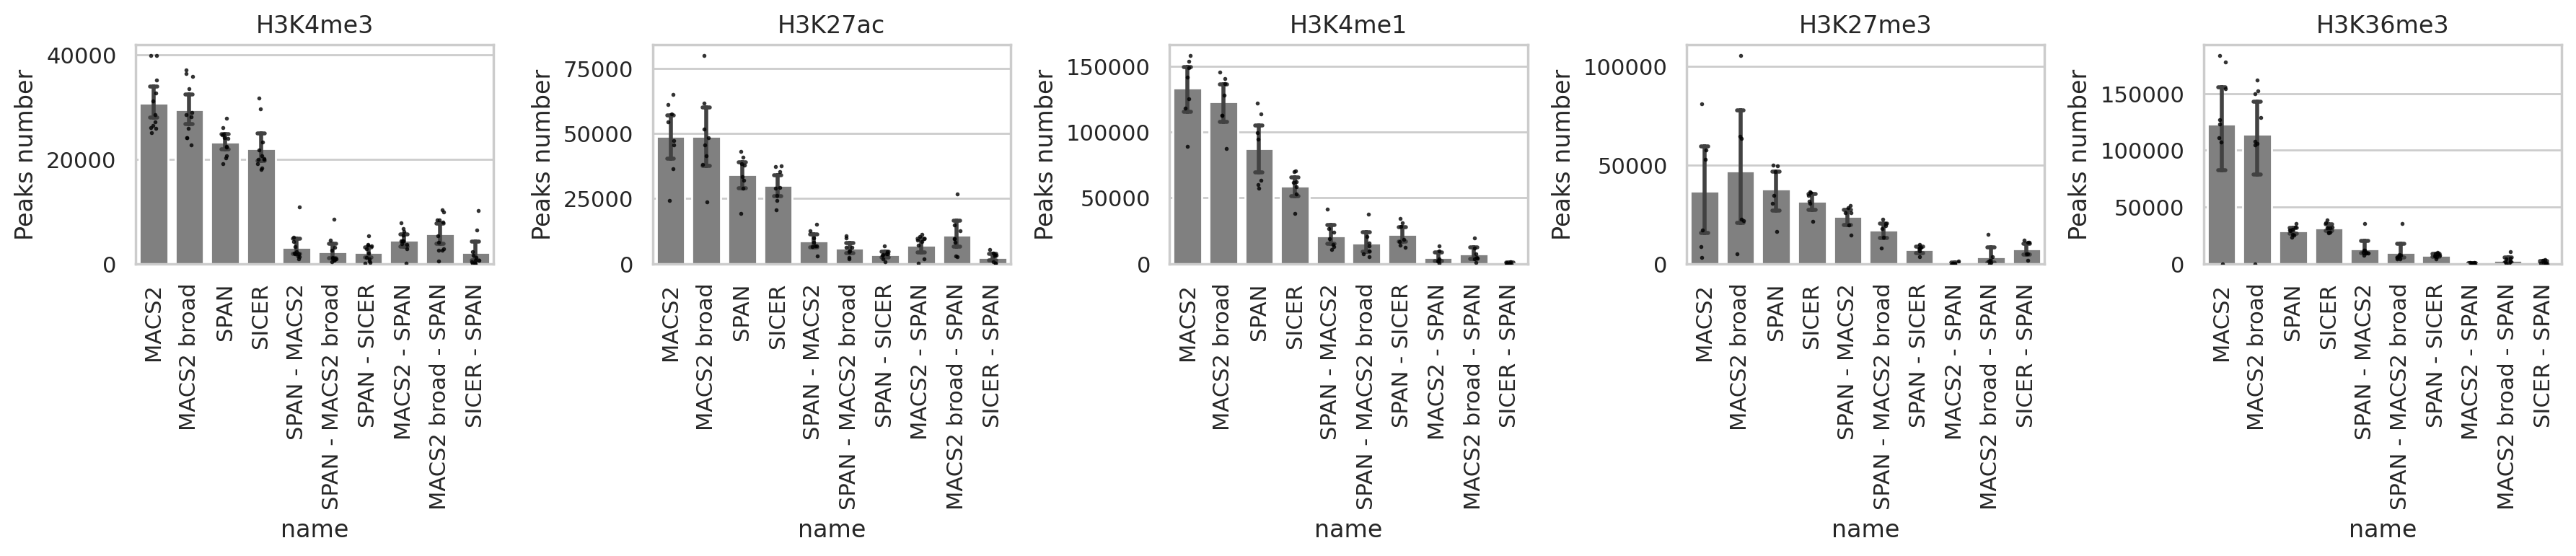

In [56]:
plot_diff(df_immune_peaks, df_immune_diff)

In [57]:
df_immune_diff[(df_immune_diff['modification'] == 'H3K27ac') &
               (df_immune_diff['name'] == 'MACS2 - SPAN')].sort_values(by=['peaks'], ascending=False).head(10)

modification      cell replicate          name  peaks
49      H3K27ac     TCell            MACS2 - SPAN  11168
19      H3K27ac       CD4            MACS2 - SPAN  10441
37      H3K27ac        NK            MACS2 - SPAN   9690
1       H3K27ac     BCell            MACS2 - SPAN   8936
31      H3K27ac  Monocyte            MACS2 - SPAN   8562
7       H3K27ac      CD34            MACS2 - SPAN   7219
13      H3K27ac      CD34      rep2  MACS2 - SPAN   3939
25      H3K27ac       CD4      rep1  MACS2 - SPAN   1824
43      H3K27ac      PBMC            MACS2 - SPAN    140

## ABF

In [58]:
dp = f'{ABF_PATH}/diff'
! mkdir -p {dp}

df_abf_diff = compute_diffs(dp, df_abf_peaks)
df_abf_diff.sample(5)

  0%|          | 0/165 [00:00<?, ?it/s]

H3K27ac OD OD1
H3K27ac OD OD10
H3K27ac OD OD11
H3K27ac OD OD12
H3K27ac OD OD13
H3K27ac OD OD14
H3K27ac OD OD15
H3K27ac OD OD16
H3K27ac OD OD17
H3K27ac OD OD18
H3K27ac OD OD19
H3K27ac OD OD2
H3K27ac OD OD20
H3K27ac OD OD3
H3K27ac OD OD4
H3K27ac OD OD5
H3K27ac OD OD6
H3K27ac OD OD7
H3K27ac OD OD8
H3K27ac OD OD9
H3K27ac YD YD10
H3K27ac YD YD11
H3K27ac YD YD12
H3K27ac YD YD14
H3K27ac YD YD15
H3K27ac YD YD16
H3K27ac YD YD17
H3K27ac YD YD18
H3K27ac YD YD19
H3K27ac YD YD2
H3K27ac YD YD20
H3K27ac YD YD21
H3K27ac YD YD3
H3K27ac YD YD4
H3K27ac YD YD5
H3K27ac YD YD7
H3K27ac YD YD8
H3K27ac YD YD9
H3K27me3 OD OD1
H3K27me3 OD OD10
H3K27me3 OD OD11
H3K27me3 OD OD12
H3K27me3 OD OD13
H3K27me3 OD OD14
H3K27me3 OD OD15
H3K27me3 OD OD16
H3K27me3 OD OD17
H3K27me3 OD OD18
H3K27me3 OD OD19
H3K27me3 OD OD2
H3K27me3 OD OD20
H3K27me3 OD OD3
H3K27me3 OD OD4
H3K27me3 OD OD5
H3K27me3 OD OD6
H3K27me3 OD OD7
H3K27me3 OD OD8
H3K27me3 YD YD12
H3K27me3 YD YD14
H3K27me3 YD YD15
H3K27me3 YD YD16
H3K27me3 YD YD17
H3K27me3

modification cell replicate          name  peaks
960      H3K4me3   YD       YD5  SPAN - MACS2  36402
425     H3K36me3   OD       OD1  SICER - SPAN   7734
406     H3K27me3   YD       YD6  SPAN - SICER   8289
856      H3K4me3   OD       OD2  SPAN - SICER   6773
773      H3K4me1   YD       YD6  SICER - SPAN    665

H3K4me3 1650
H3K27ac 1650
H3K4me1 1650
H3K27me3 1650
H3K36me3 1650


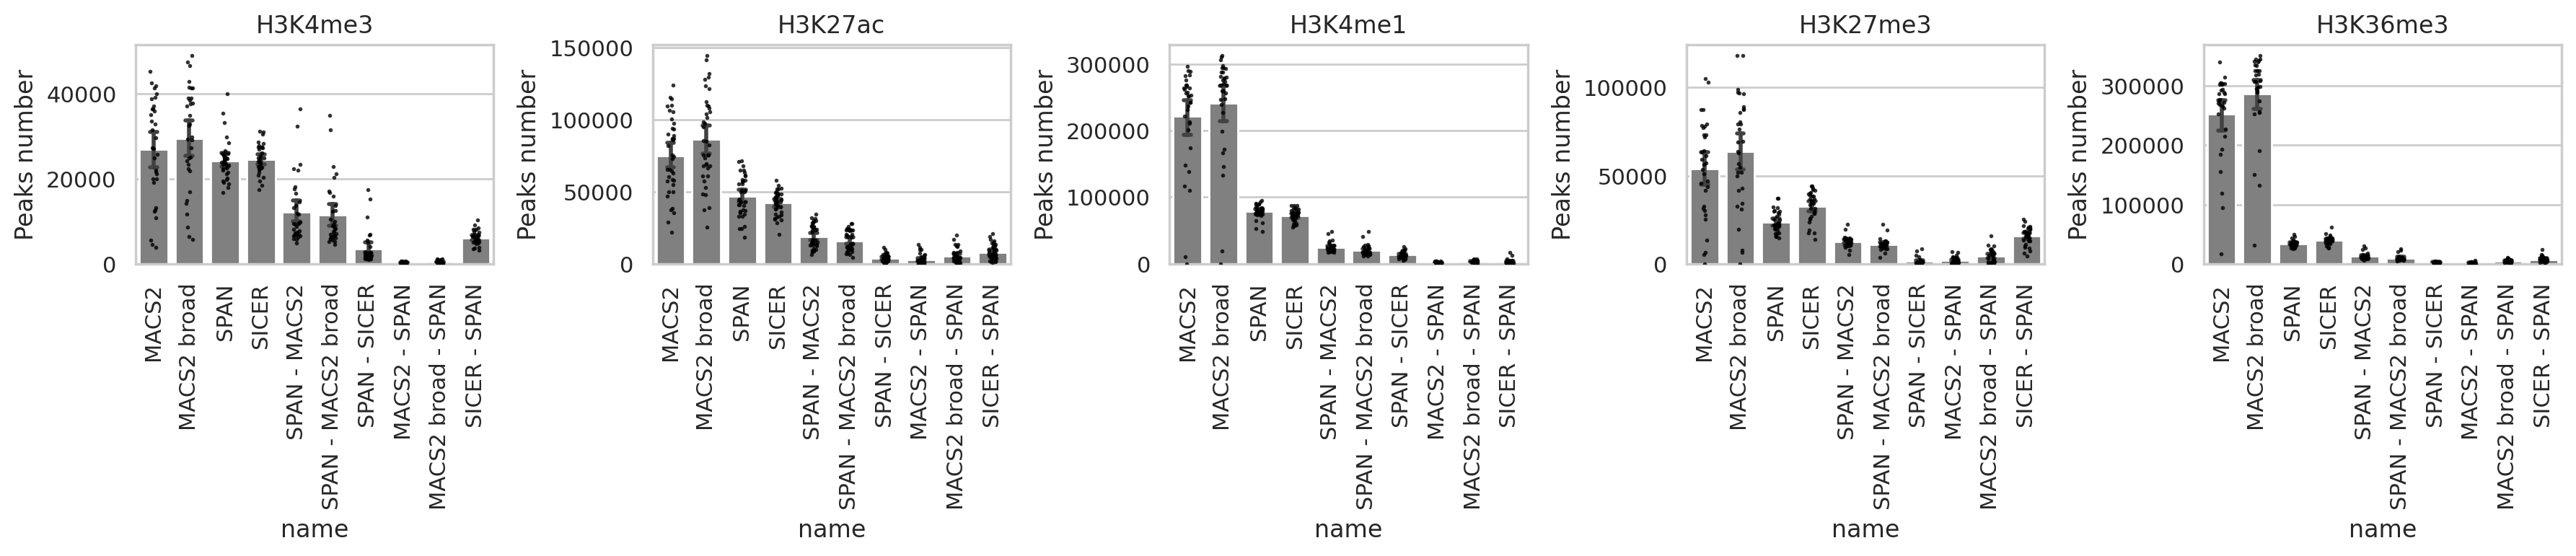

In [59]:
plot_diff(df_abf_peaks, df_abf_diff)


# Jaccard & Overlap

In [60]:
import pyranges as pr
import tempfile

def compute_reps_overlap(df_peaks):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    for (m, c, tool), tm in tqdm(df_peaks.groupby(['modification', 'cell', 'tool'])):
        reps = list(sorted(set(tm['replicate'])))
        print(m, c, tool, len(reps))
        files = [None] * len(reps)
        peaks = [-1] * len(reps)
        peaks_lens = [-1] * len(reps)
        # print('Load')
        for i in range(len(reps)):
            t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == reps[i])]
            if len(t1) == 0:
                continue
            file = t1['file'].values[0]
            peaks[i] = lines(file)
            if peaks[i] == 0:
                peaks_lens[i] = 0
                continue
            files[i] = pr.read_bed(sorted_file(file))
            peaks_lens[i] = files[i].lengths().sum()
            # print('Intersect')
        for i, j in product(range(len(reps)), range(len(reps))):
            if i >= j:
                continue
            rep1, rep2 = reps[i], reps[j]
            file1, file2 = files[i], files[j]
            peaks1, peaks2 = peaks[i], peaks[j]
            peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
            if peaks1 <= 0 or peaks2 <= 0:
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     0, 0, 0)
                continue
            overlap1 = len(file1.overlap(file2))
            overlap2 = len(file2.overlap(file1))
            overlap_len = file1.intersect(file2).lengths().sum()
            # assert file2.intersect(file1).lengths().sum() == overlap_len
            reps_overlap.loc[len(reps_overlap)] = \
                (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                 overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

## Jaccard ENCODE 

In [61]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
df_encode_reps = compute_reps_overlap(t)
df_encode_reps.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K27ac GM12878 MACS2 2
H3K27ac GM12878 MACS2 broad 2
H3K27ac GM12878 SICER 2
H3K27ac GM12878 SPAN 2
H3K27ac H1 MACS2 1
H3K27ac H1 MACS2 broad 1
H3K27ac H1 SICER 1
H3K27ac H1 SPAN 1
H3K27ac HMEC MACS2 2
H3K27ac HMEC MACS2 broad 2
H3K27ac HMEC SICER 2
H3K27ac HMEC SPAN 2
H3K27ac HSMM MACS2 2
H3K27ac HSMM MACS2 broad 2
H3K27ac HSMM SICER 2
H3K27ac HSMM SPAN 2
H3K27ac HepG2 MACS2 2
H3K27ac HepG2 MACS2 broad 2
H3K27ac HepG2 SICER 2
H3K27ac HepG2 SPAN 2
H3K27ac Huvec MACS2 2
H3K27ac Huvec MACS2 broad 2
H3K27ac Huvec SICER 2
H3K27ac Huvec SPAN 2
H3K27ac K562 MACS2 2
H3K27ac K562 MACS2 broad 2
H3K27ac K562 SICER 2
H3K27ac K562 SPAN 2
H3K27ac NHEK MACS2 2
H3K27ac NHEK MACS2 broad 2
H3K27ac NHEK SICER 2
H3K27ac NHEK SPAN 2
H3K27ac NHLF MACS2 2
H3K27ac NHLF MACS2 broad 2
H3K27ac NHLF SICER 2
H3K27ac NHLF SPAN 2
H3K27me3 GM12878 MACS2 2
H3K27me3 GM12878 MACS2 broad 2
H3K27me3 GM12878 SICER 2
H3K27me3 GM12878 SPAN 2
H3K27me3 H1 MACS2 2
H3K27me3 H1 MACS2 broad 2
H3K27me3 H1 SICER 2
H3K27me3 H1 SPAN

modification   cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
48      H3K27me3  HepG2        MACS2  rep1  rep2    4259     1592954       0   
27       H3K27ac   NHEK         SPAN  rep1  rep2   48640    59198900   44091   
5        H3K27ac   HMEC  MACS2 broad  rep1  rep2   39794    29503681   56463   
157      H3K4me3   NHEK  MACS2 broad  rep1  rep2   42801    41899282   35868   
38      H3K27me3     H1        SICER  rep1  rep2   10605    43995595   13713   

     peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
48            0               0               0                  0  0.000000  
27     50789870           34397           34826           39177480  0.553266  
5      58826874           34170           27385           24570714  0.385363  
157    34418235           24481           28038           27038103  0.548669  
38     92408087            9579            8193           40611897  0.423960

ENCODE


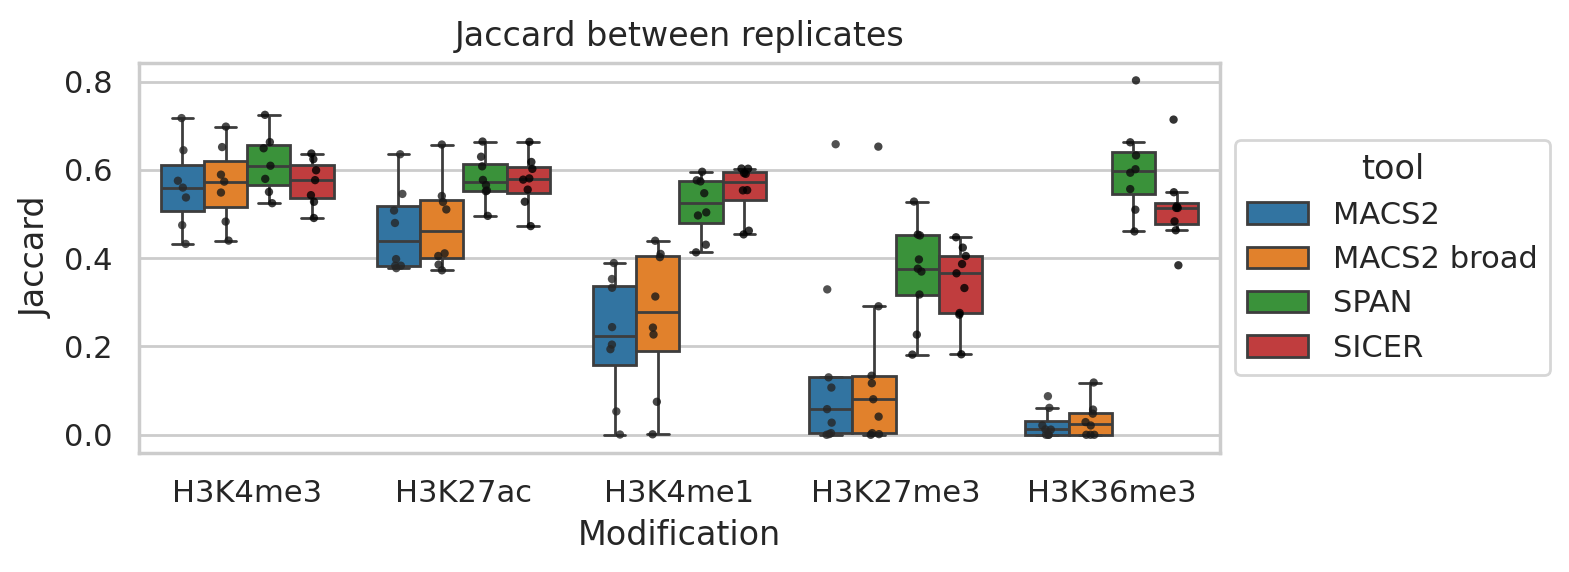

In [62]:
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


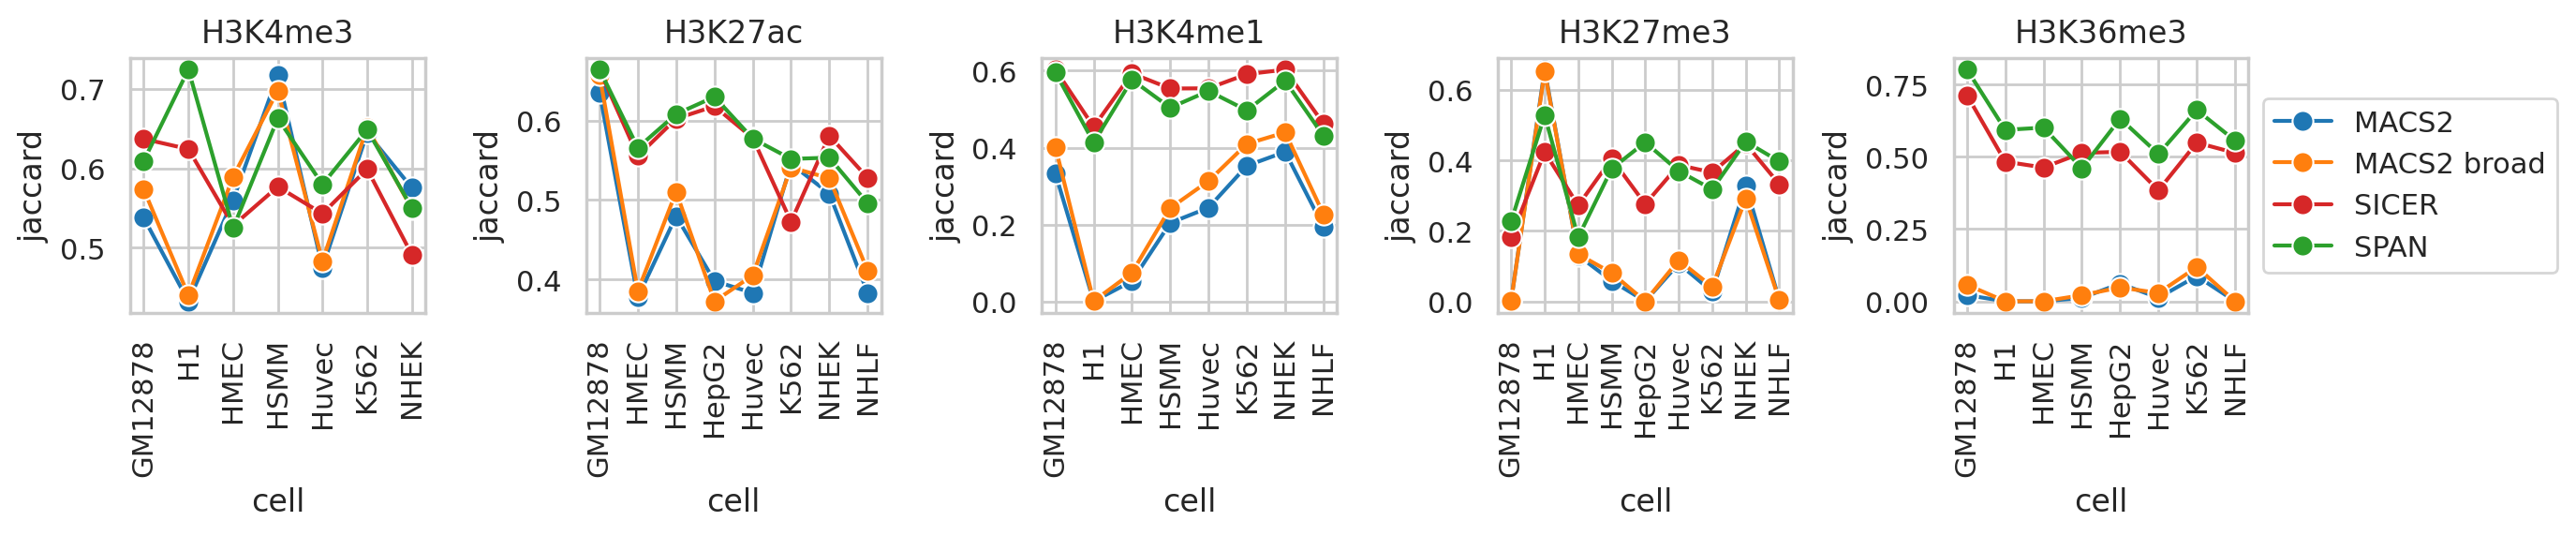

In [63]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


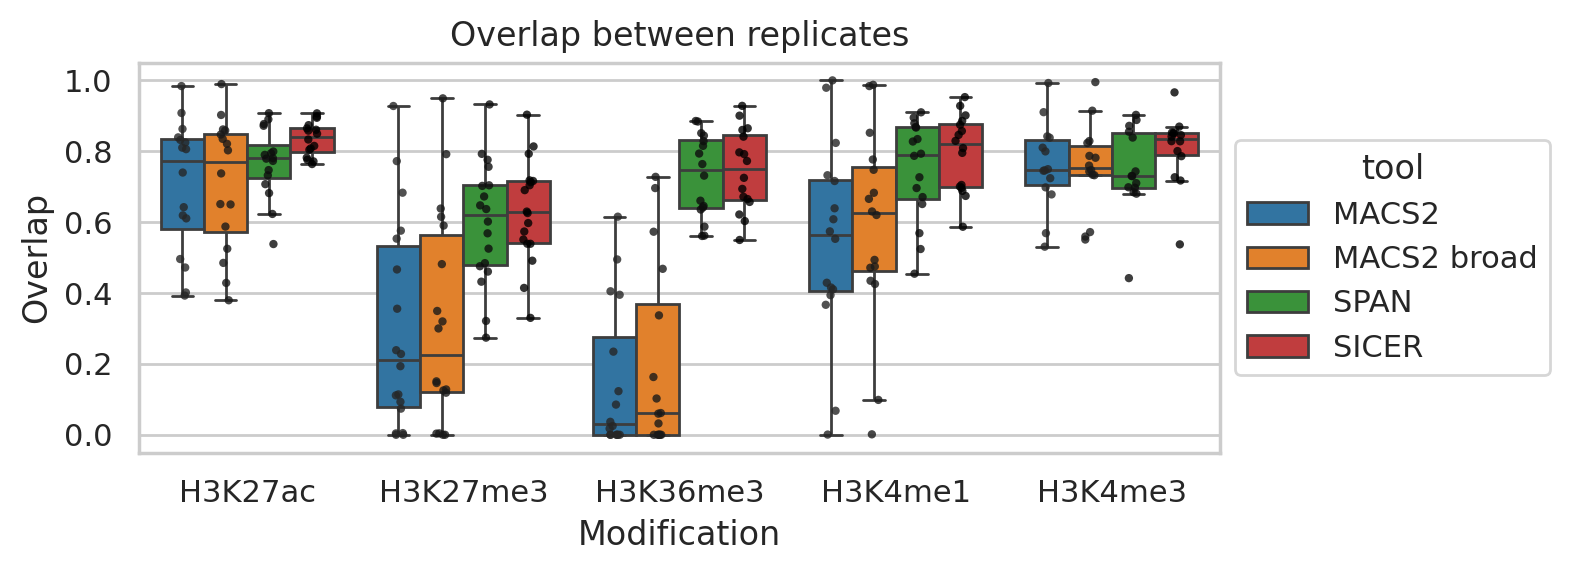

In [64]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']],
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False
            )
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


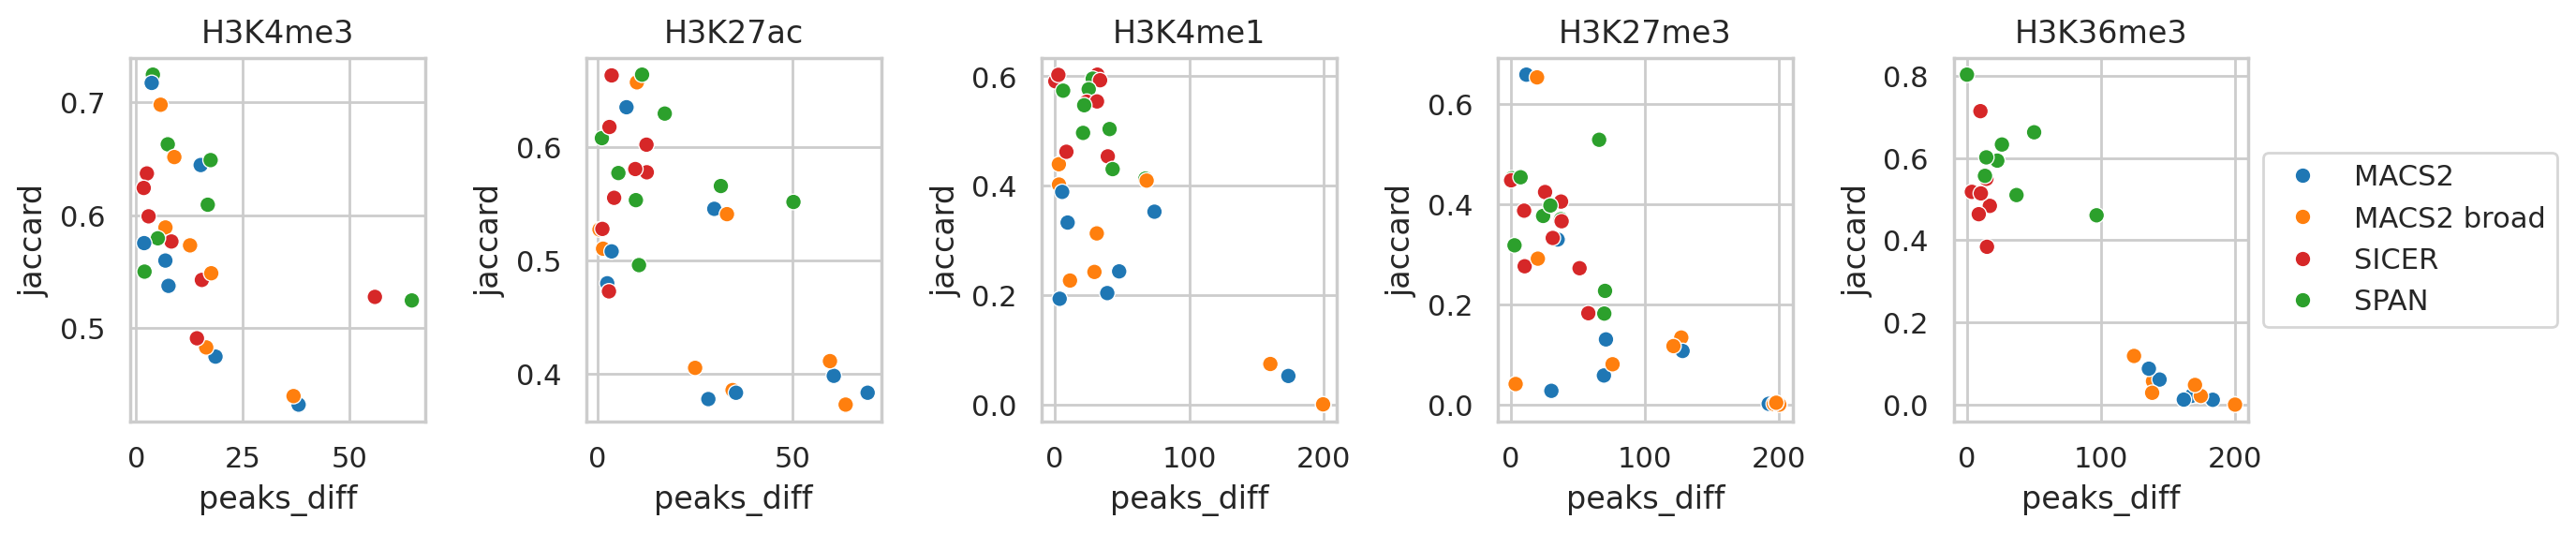

In [65]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

ENCODE


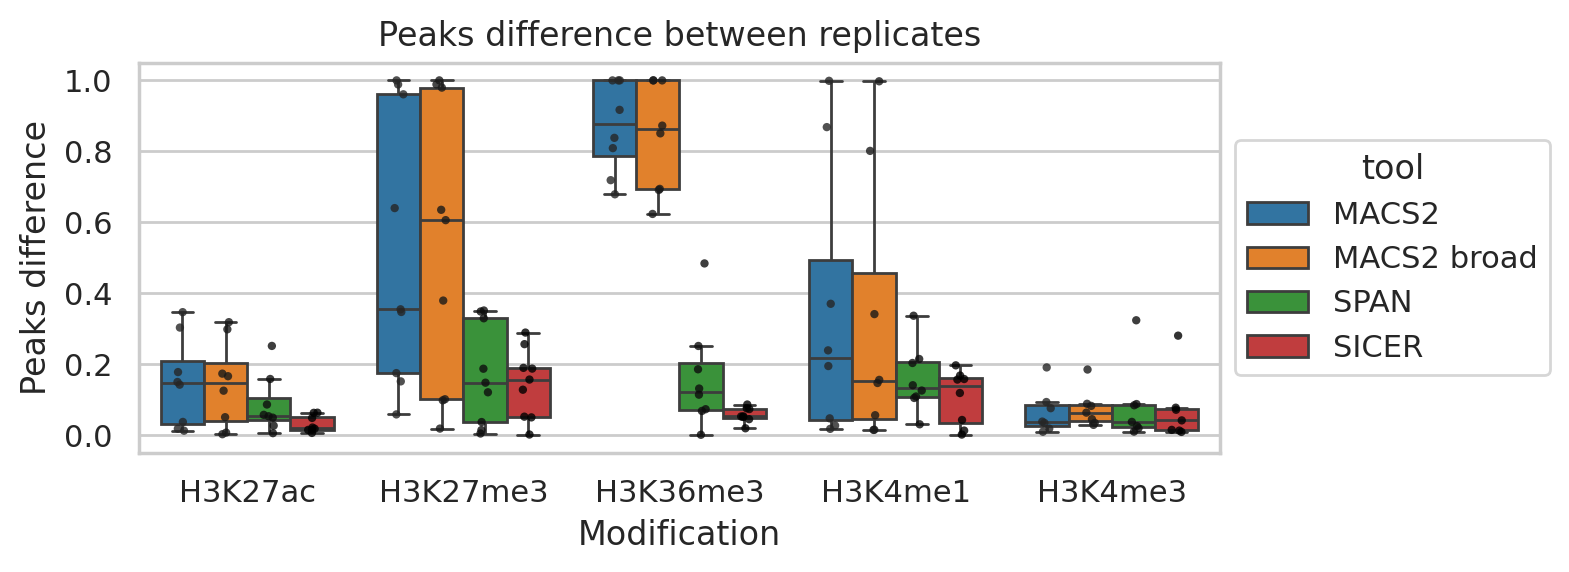

In [66]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [67]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

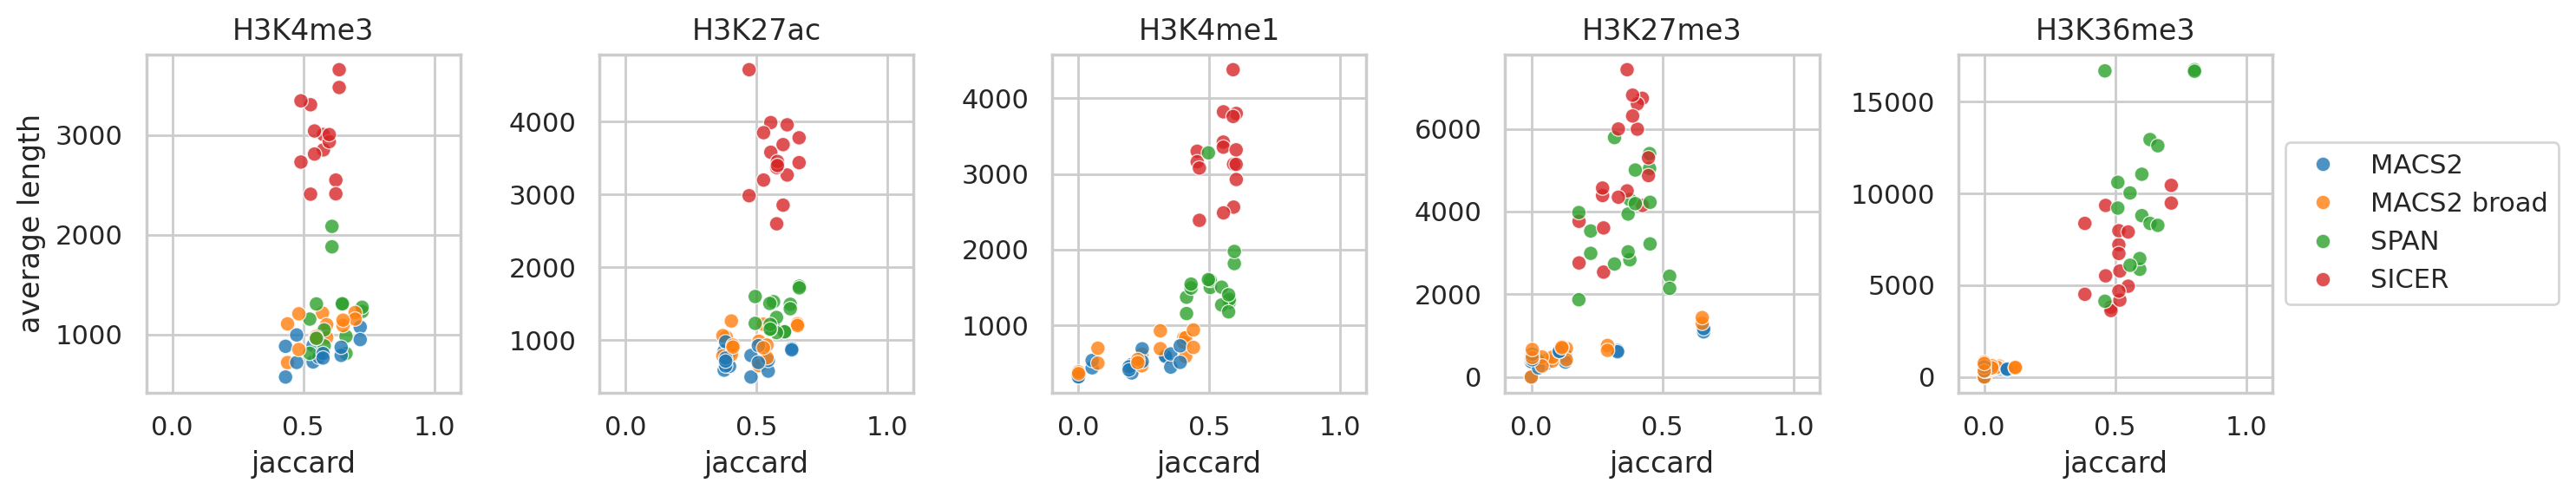

In [68]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


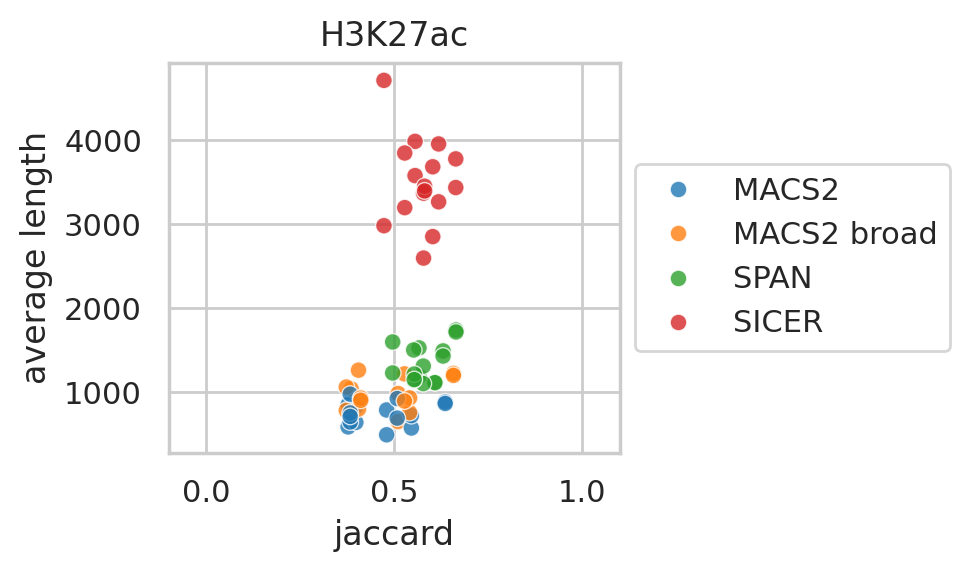

H3K4me1


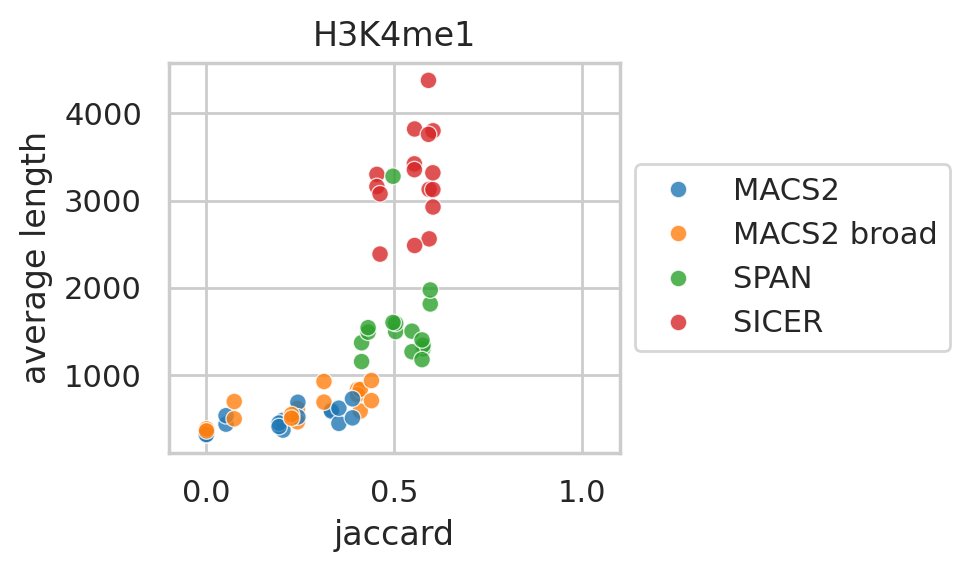

In [69]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [70]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t)
df_immune_reps.sample(5)

  0%|          | 0/120 [00:00<?, ?it/s]

H3K27ac BCell MACS2 1
H3K27ac BCell MACS2 broad 1
H3K27ac BCell SICER 1
H3K27ac BCell SPAN 1
H3K27ac CD34 MACS2 1
H3K27ac CD34 MACS2 broad 1
H3K27ac CD34 SICER 1
H3K27ac CD34 SPAN 1
H3K27ac CD4 MACS2 2
H3K27ac CD4 MACS2 broad 2
H3K27ac CD4 SICER 2
H3K27ac CD4 SPAN 2
H3K27ac Monocyte MACS2 1
H3K27ac Monocyte MACS2 broad 1
H3K27ac Monocyte SICER 1
H3K27ac Monocyte SPAN 1
H3K27ac NK MACS2 1
H3K27ac NK MACS2 broad 1
H3K27ac NK SICER 1
H3K27ac NK SPAN 1
H3K27ac PBMC MACS2 1
H3K27ac PBMC MACS2 broad 1
H3K27ac PBMC SICER 1
H3K27ac PBMC SPAN 1
H3K27ac TCell MACS2 1
H3K27ac TCell MACS2 broad 1
H3K27ac TCell SICER 1
H3K27ac TCell SPAN 1
H3K27me3 CD34 MACS2 2
H3K27me3 CD34 MACS2 broad 2
H3K27me3 CD34 SICER 2
H3K27me3 CD34 SPAN 2
H3K27me3 CD4 MACS2 2
H3K27me3 CD4 MACS2 broad 2
H3K27me3 CD4 SICER 2
H3K27me3 CD4 SPAN 2
H3K27me3 Monocyte MACS2 1
H3K27me3 Monocyte MACS2 broad 1
H3K27me3 Monocyte SICER 1
H3K27me3 Monocyte SPAN 1
H3K27me3 PBMC MACS2 1
H3K27me3 PBMC MACS2 broad 1
H3K27me3 PBMC SICER 1
H3

modification  cell   tool rep1  rep2  peaks1  peaks1_len  peaks2  \
2       H3K27ac   CD4  SICER       rep1   37659   153413341   20712   
6      H3K27me3  CD34  SICER       rep2   30576   223452424   36287   
10     H3K27me3   CD4  SICER       rep2   21617   135717383   31631   
28      H3K4me3  CD34  MACS2       rep2   39952    29326644   27221   
8      H3K27me3   CD4  MACS2       rep2    3126     1004365    8738   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
2     59693688           17728           19447           53601523  0.336048  
6    254671913           24855           23574          166002666  0.531852  
10   174628769           14444           15169           69609885  0.289154  
28    24341167           27566           24847           21768624  0.682419  
8      3386228            1645            1544             446731  0.113272

Immune


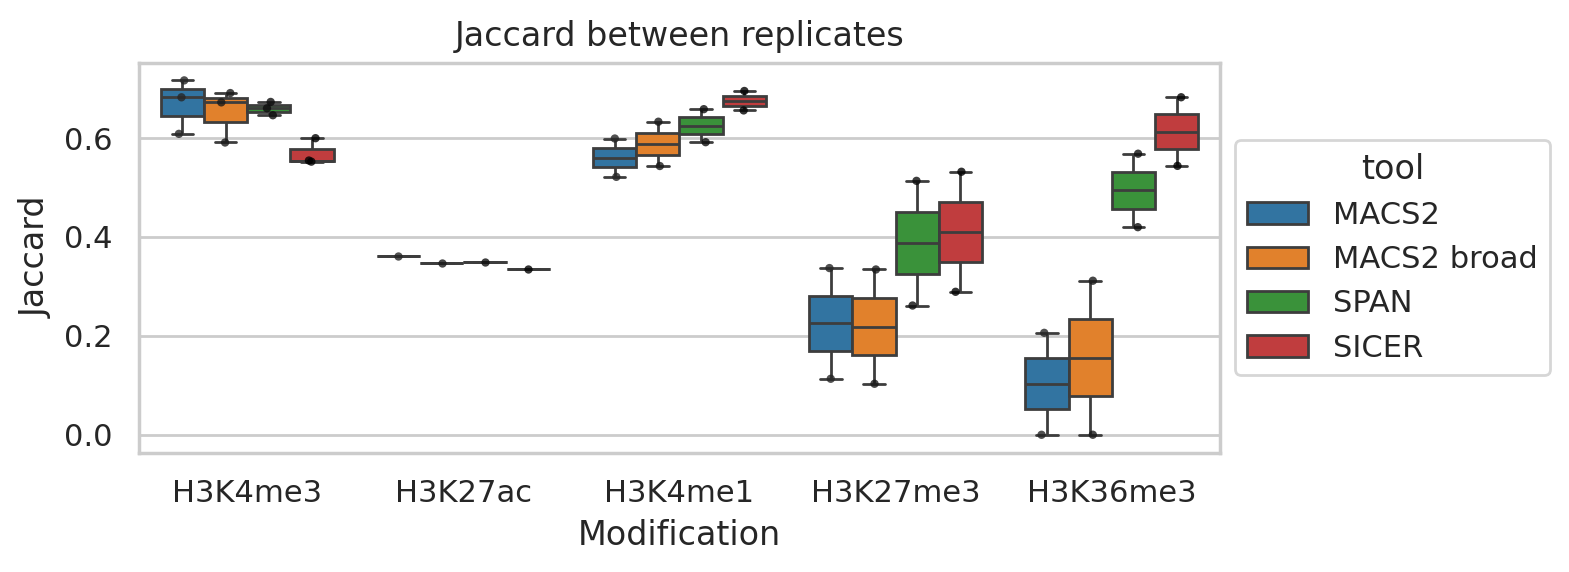

In [71]:
print('Immune')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


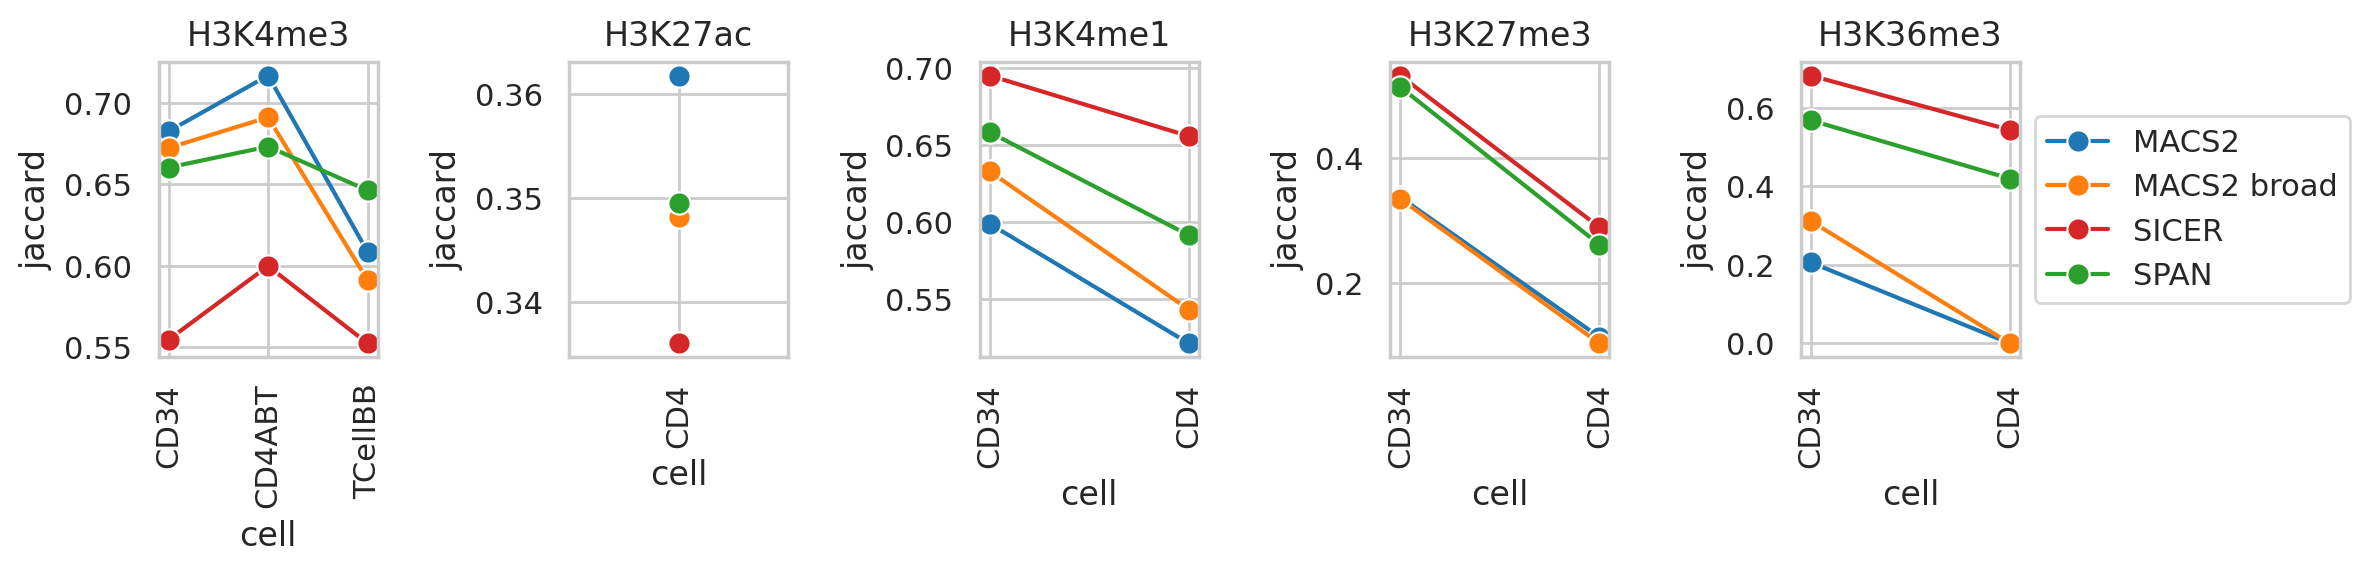

In [72]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


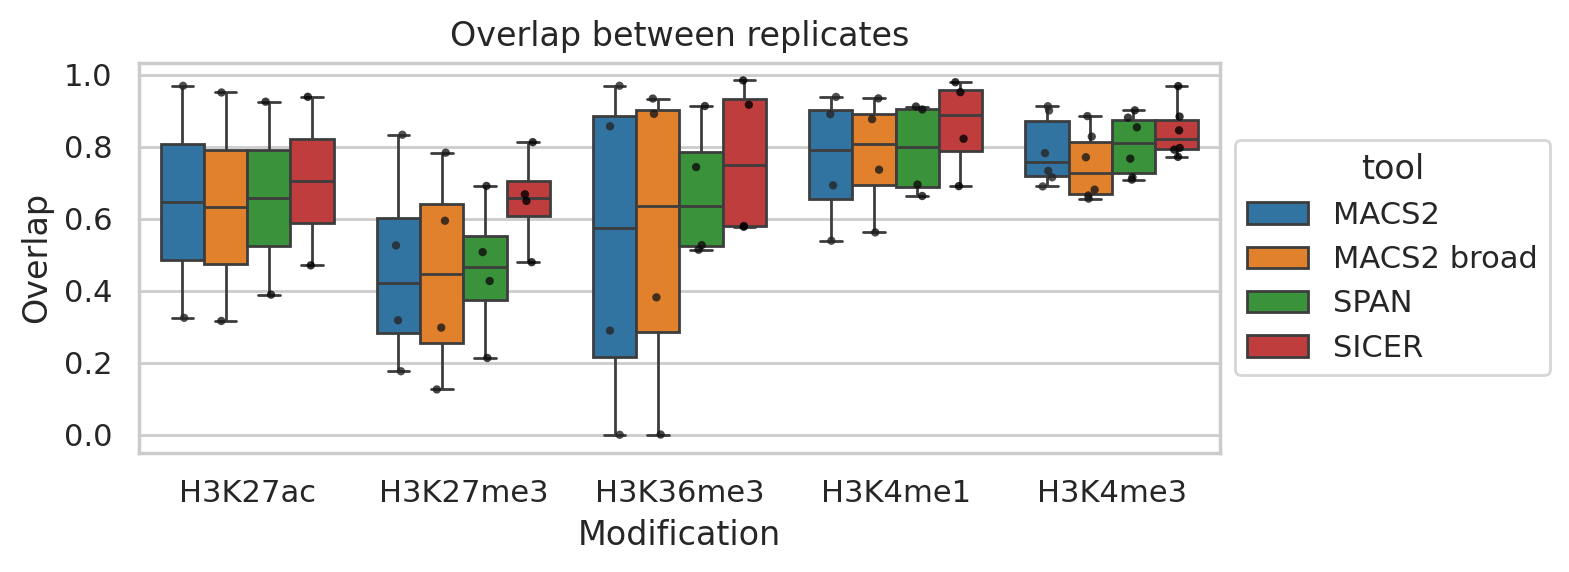

In [73]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


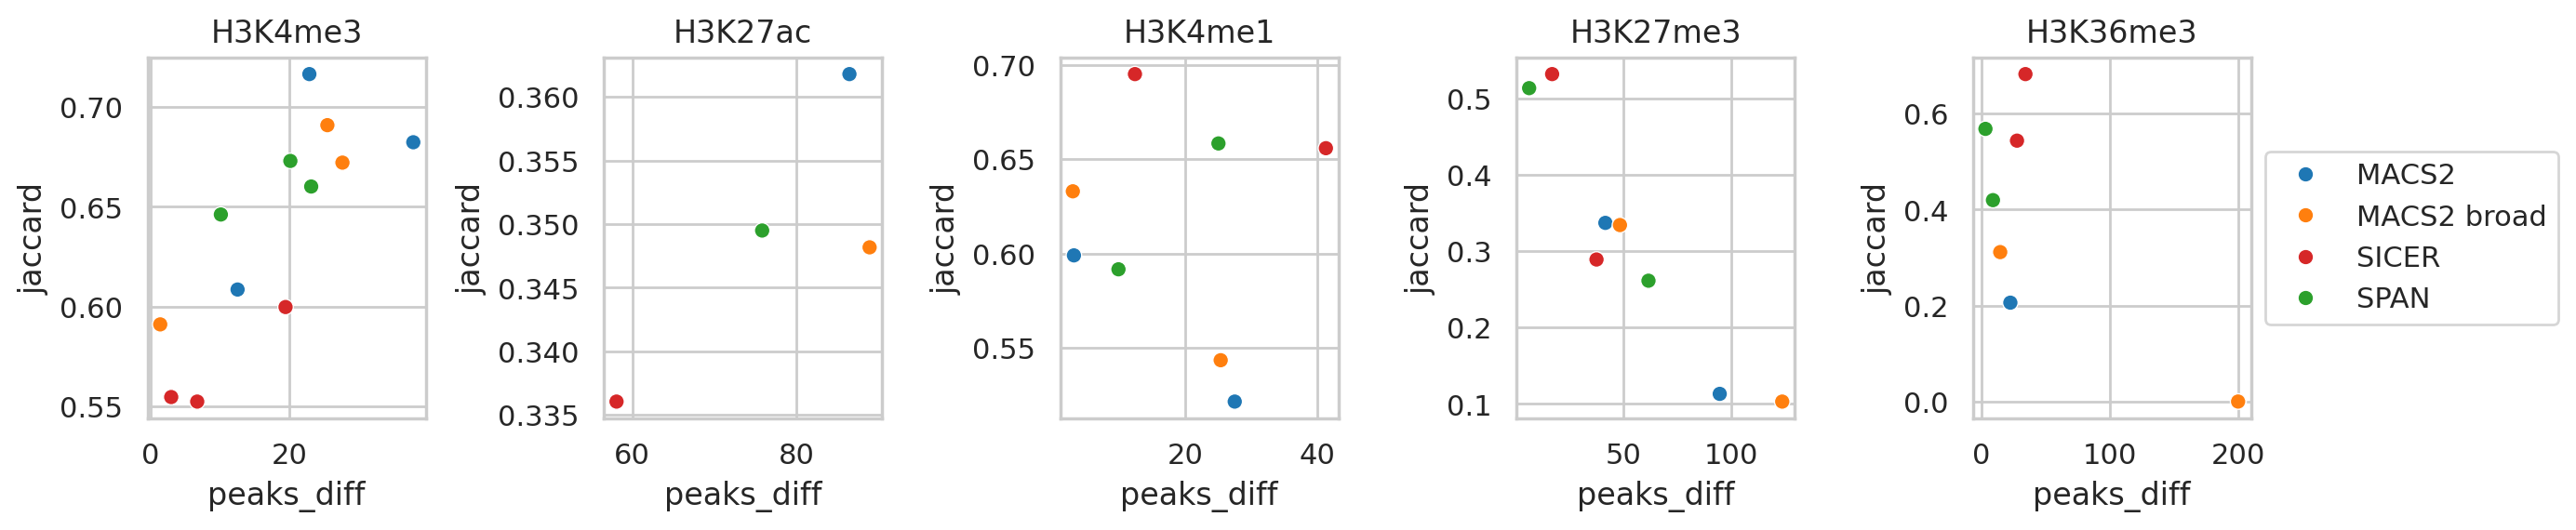

In [74]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Immune


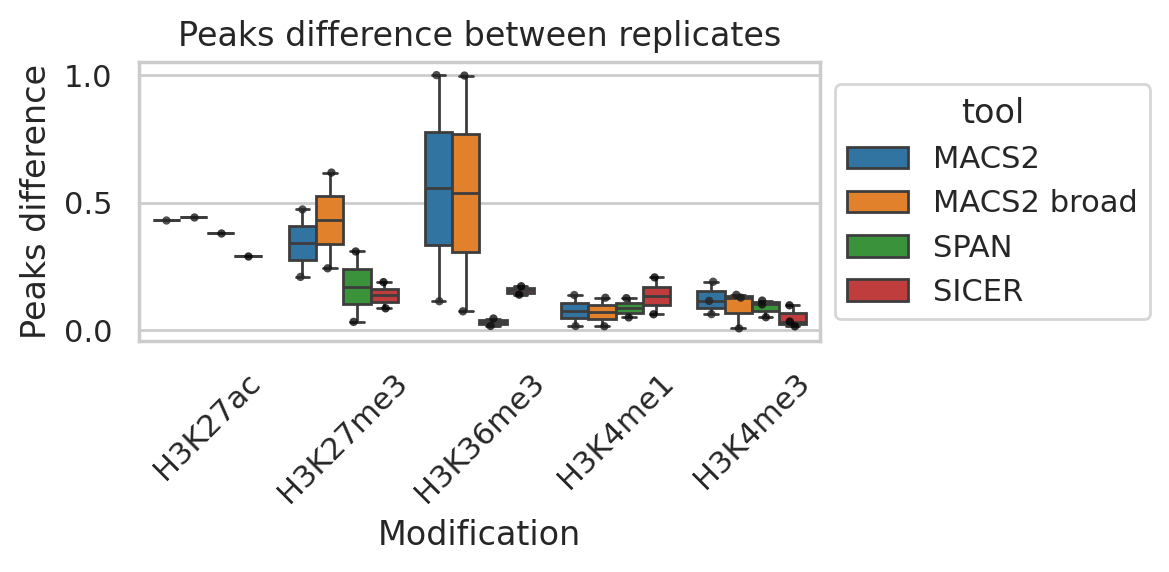

In [75]:
sns.set_style('whitegrid')
print('Immune')
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))

plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [76]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

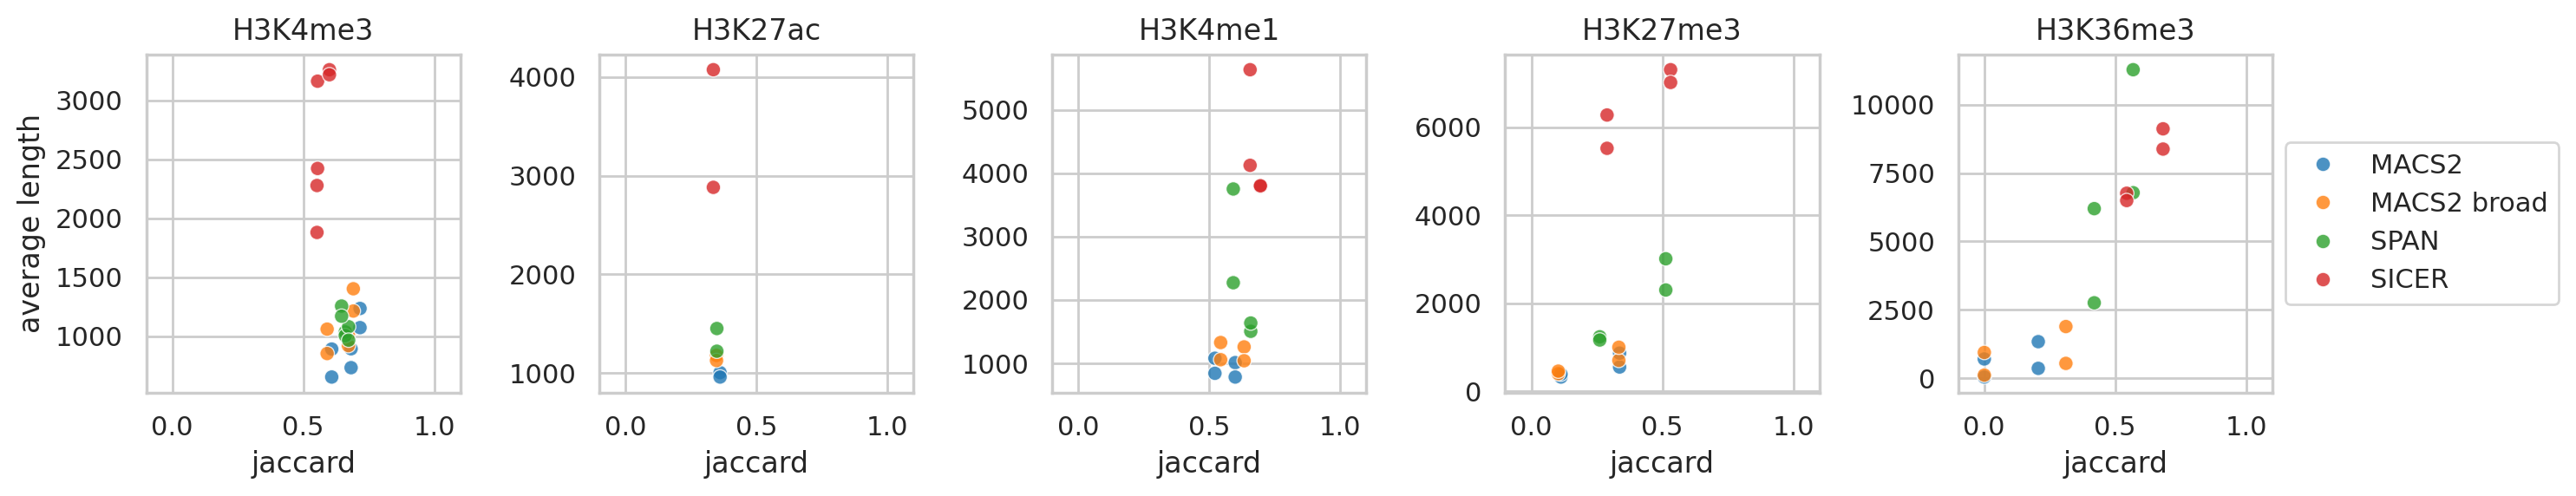

In [77]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## All

ENCODE + Roadmap


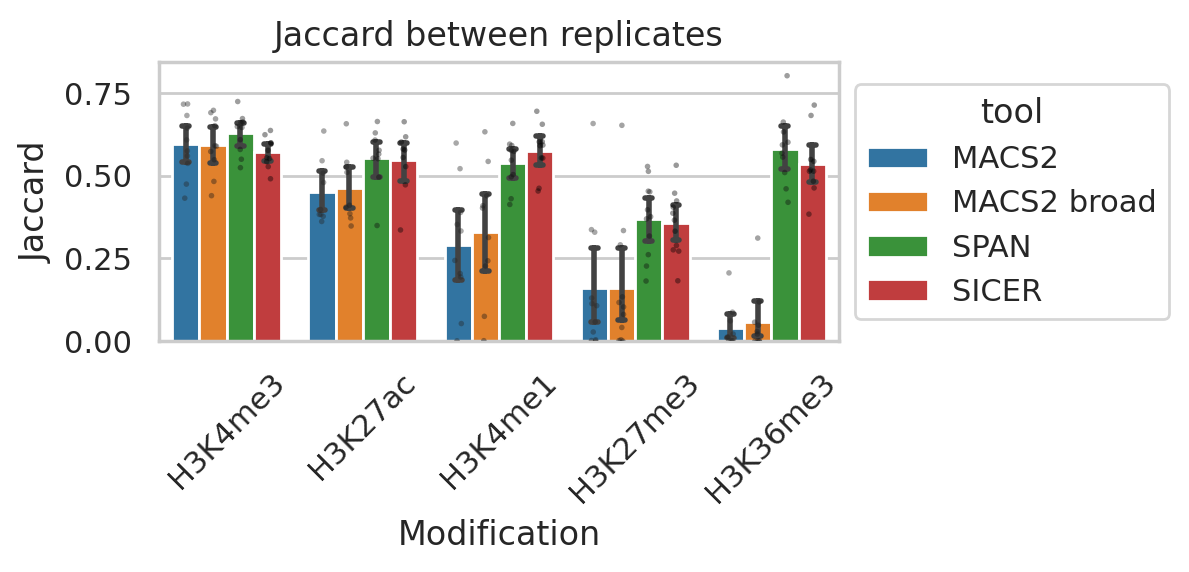

In [78]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black',
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False, alpha=0.4,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


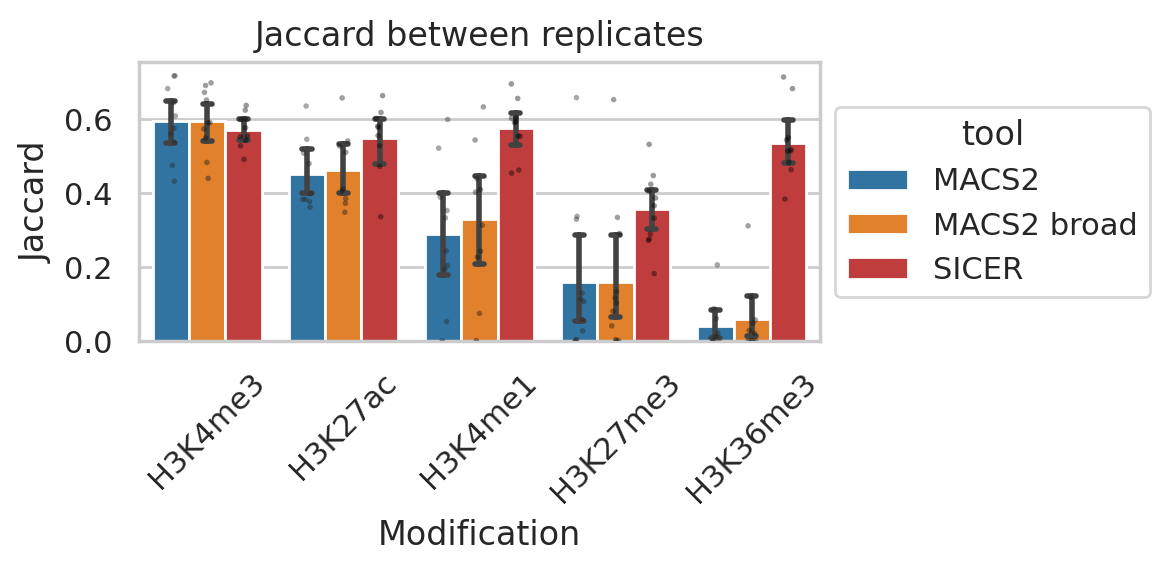

In [79]:
print('ENCODE + Roadmap')
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black', alpha=0.4,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [80]:
ts = []
# for df in [df_encode_reps, df_immune_reps, df_abf_reps]:
for df in [df_encode_reps, df_immune_reps]:
    t = pd.concat([df[['modification', 'cell', 'tool']],
                   df[['modification', 'cell', 'tool']]]).reset_index(drop=True)
    overlaps = [d(o, p) for o, p in zip(df['peaks1_overlap'], df['peaks1'])] + \
               [d(o, p) for o, p in zip(df['peaks2_overlap'], df['peaks2'])]
    t['overlap'] = overlaps
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)

All


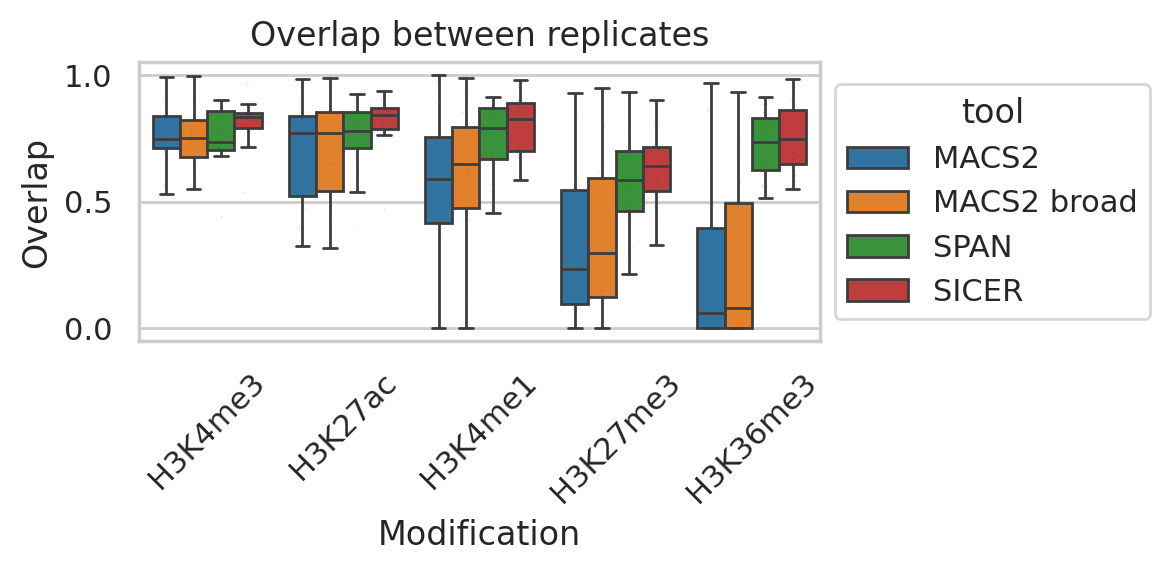

In [81]:
print('All')
sns.set_style("whitegrid")

plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.stripplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=0.2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


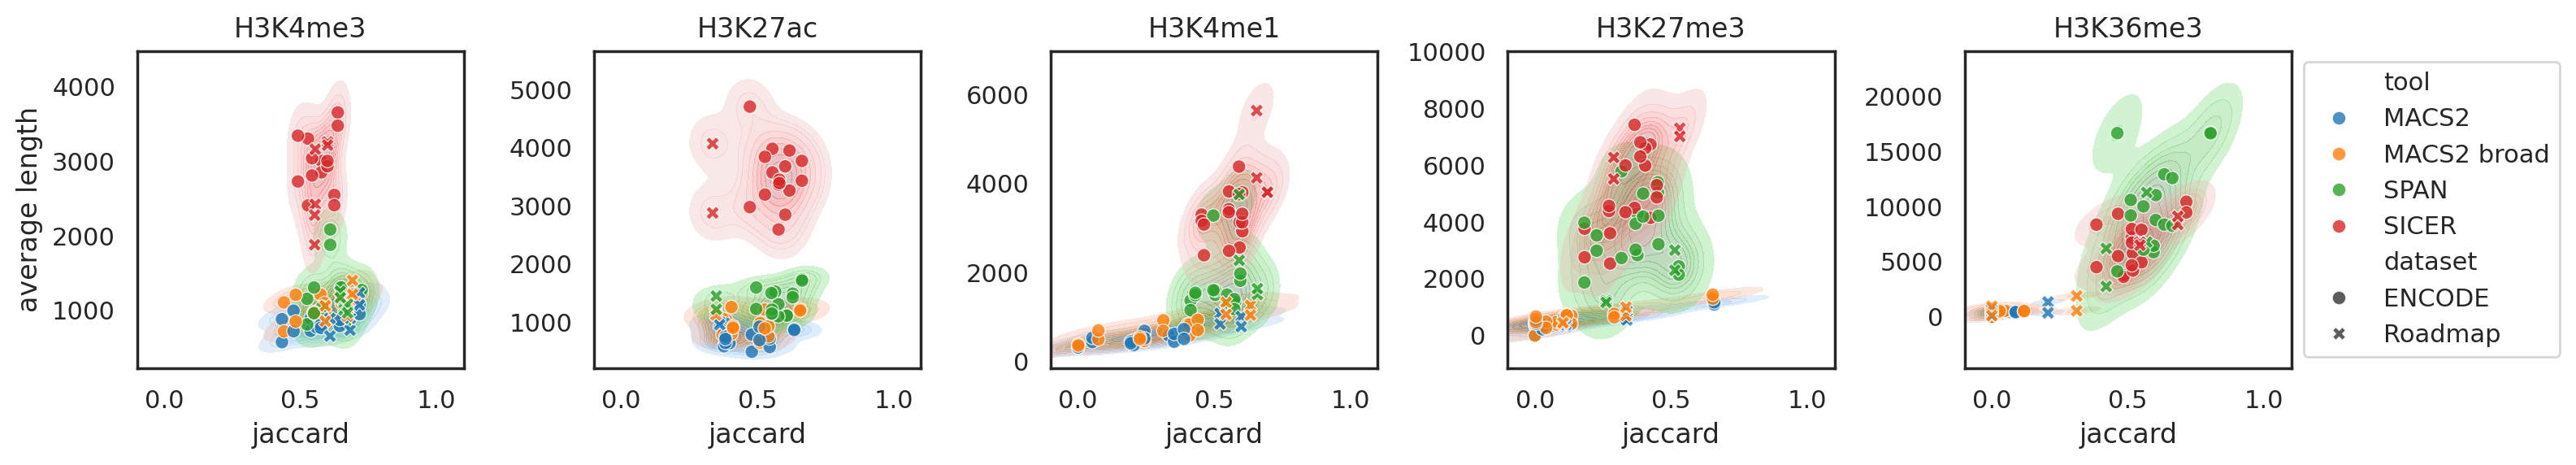

In [82]:
print('ENCODE + Roadmap')
sns.set_style("white")
# t = df_jaccard_avg_len_encode
df_jaccard_avg_len_encode['dataset'] = 'ENCODE'
df_jaccard_avg_len_immune['dataset'] = 'Roadmap'
t = pd.concat([df_jaccard_avg_len_encode, df_jaccard_avg_len_immune]).reset_index(drop=True)
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.3,
        common_norm=False, common_grid=False,
        thresh=.05,
        fill=True,
        ax=ax,
    )
    sns.scatterplot(
        t[t['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        style='dataset',
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    # ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Jaccard ABF

In [83]:
df_abf_reps = compute_reps_overlap(df_abf_peaks)
df_abf_reps.sample(5)

  0%|          | 0/40 [00:00<?, ?it/s]

H3K27ac OD MACS2 20
H3K27ac OD MACS2 broad 20
H3K27ac OD SICER 20
H3K27ac OD SPAN 20
H3K27ac YD MACS2 18
H3K27ac YD MACS2 broad 18
H3K27ac YD SICER 18
H3K27ac YD SPAN 18
H3K27me3 OD MACS2 19
H3K27me3 OD MACS2 broad 19
H3K27me3 OD SICER 19
H3K27me3 OD SPAN 19
H3K27me3 YD MACS2 13
H3K27me3 YD MACS2 broad 13
H3K27me3 YD SICER 13
H3K27me3 YD SPAN 13
H3K36me3 OD MACS2 15
H3K36me3 OD MACS2 broad 15
H3K36me3 OD SICER 15
H3K36me3 OD SPAN 15
H3K36me3 YD MACS2 15
H3K36me3 YD MACS2 broad 15
H3K36me3 YD SICER 15
H3K36me3 YD SPAN 15
H3K4me1 OD MACS2 17
H3K4me1 OD MACS2 broad 17
H3K4me1 OD SICER 17
H3K4me1 OD SPAN 17
H3K4me1 YD MACS2 15
H3K4me1 YD MACS2 broad 15
H3K4me1 YD SICER 15
H3K4me1 YD SPAN 15
H3K4me3 OD MACS2 17
H3K4me3 OD MACS2 broad 17
H3K4me3 OD SICER 17
H3K4me3 OD SPAN 17
H3K4me3 YD MACS2 16
H3K4me3 YD MACS2 broad 16
H3K4me3 YD SICER 16
H3K4me3 YD SPAN 16


modification cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
4247      H3K4me3   OD        MACS2  OD15  OD20   25797     6849738   42630   
932       H3K27ac   YD  MACS2 broad  YD11  YD15  128001    41512359  123599   
77        H3K27ac   OD        MACS2  OD13  OD20   90146    43431021   97574   
2905     H3K36me3   YD  MACS2 broad  YD10   YD8  190171    53618863  319102   
4992      H3K4me3   YD        SICER  YD12   YD4   22248    71619752   20786   

      peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
4247    15994067           25397           18088            6692804  0.414389  
932     46050228           74735           66902           27180513  0.450142  
77      41761767           67499           74618           33606458  0.651461  
2905   120440901          169147          136815           46323830  0.362653  
4992   105001214           15150           14380           43747265  0.329239

ABF


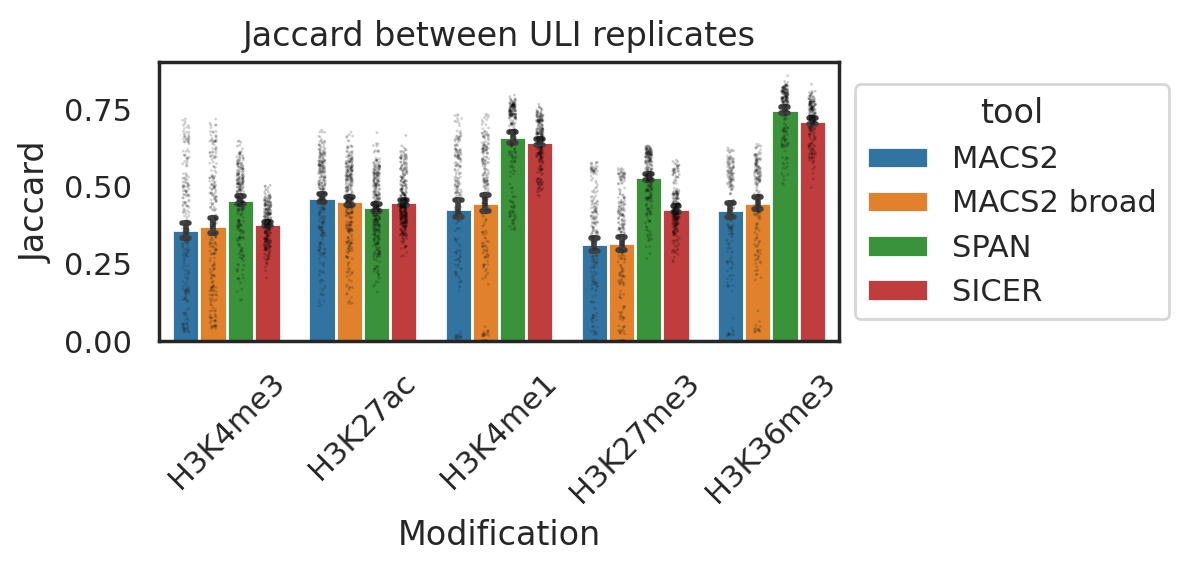

In [84]:
print('ABF')
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
            order=MODIFICATIONS,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=1, palette='dark:black', alpha=0.2,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between ULI replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ABF


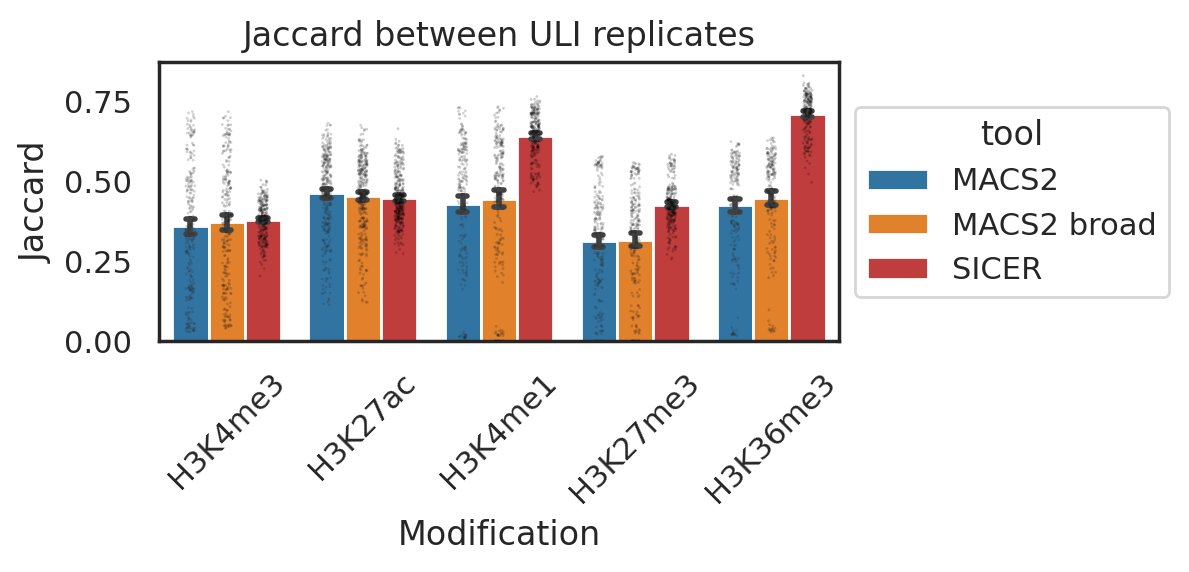

In [85]:
print('ABF')
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.barplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
            order=MODIFICATIONS,
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SICER'],
            capsize=.2, err_kws={'linewidth': 2},
            ax=ax)
sns.stripplot(data=df_abf_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=1, palette='dark:black', alpha=0.2,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between ULI replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END